In [1]:
%%HTML
<a href="https://fr.openfoodfacts.org/" target="_blank"><img src=".\OpenFoodFacts.png" alt="Ce projet utilise les données d'Open Food Facts" />

<a id="sommaire"></a>
## Rappel de la mission et démarche utilisée
La mission de ce projet consiste à proposer une idée innovante d'application en lien avec l'alimentation et s'appuyant sur le jeu de données Open Food Facts.

Dans ce but, nous avons suivi la démarche ci-après.

**Parties 1 à 3 - voir le Notebook de nettoyage** : à l'issue de ces étapes est produit le jeu de données enregistré sous le nom 'data_notebook_01.csv'.

**Rappel de l'application envisagée :**
1) L'utilisation de l'application est envisagée sur la base des produits disponibles en France.

2) L'utilisateur entre une demande combinant :
   - les types d'apport nutritionnel à contenir concernant les vitamines et sels minéraux ;
   - les types d'apport nutritionnel à minimiser concernant le sel, le sucres, les graisses saturées ou les graisses trans ;
   - d'éventuels éléments à exclure en termes d'allergènes, d'huile de palme, et d'additifs.

3) L'application propose en retour une liste des meilleurs produits classés selon leur qualité en termes de score nutritionnel.

4) À partir d'un produit de la liste, l'utilisateur a la possibilité d'élargir sa recherche à d’autres produits en fonction de catégorie.

**[Partie 4 - Notebook d'analyse exploratoire - Analyse uni-variée et bi-variée](#analyse_uni_bi)**, dont l'objectif est de valider que le jeu de données est prêt et pertinent pour l'application envisagée :
- [Analyse uni-variée](#analyse_uni) :
    - [Caractéristiques numériques](#analyse_uni_num) ;
    - [Caractéristiques catégorielles](#analyse_uni_cat).
- [Analyse bi-variée](#analyse_bi) :
    - [Caractéristiques numériques entre elles](#analyse_bi_num) ;
    - [Caractéristiques mixtes numériques / catégorielles](#analyse_bi_num_cat).

**[Partie 5 - Notebook d'analyse exploratoire - Analyse multi-variée](#analyse_multi)** :
- [Analyse en composantes principales (ACP)](#acp) : corrélation des variables numériques entre elles ;
- [ANOVA (ANalysis Of VAriance) et tests statistiques associés](#anova) : corrélation entre caractéristique numérique et caractéristique catégorielle avec test de Fisher et calcul de p-value.

**[Partie 6 - Notebook d'analyse exploratoire - Application](#appli)** : première maquette de l'application

**[Conclusion](#conclusion)**

## Moyens utilisés
Ce projet est mené en langage Python, utilisant principalement les librairies Numpy, Pandas, Matplotlib et Seaborn.

Le rapport est constitué des fichiers suivants :
- Notebook de nettoyage : PSante_01_notebooknettoyage.ipynb
- Notebook d'analyse exploratoire : PSante_02_notebookanalyse.ipynb
- Présentation en support de la soutenance : PSante_03_presentation.pdf
- Fichier des fonctions Python utilisées par les notebooks : PSante_04_fonctions.py

L'étude est menée avec l'IDE Pycharm, Python 3.9.7 et des librairies spécifiées dans requirements.txt.

<a id="init"></a>
## Import des librairies et fonctions, chargement du jeu de données et définition des variables
- Variable structurelles (familles): products, composition, product_categories, vitamins, minerals, toMinimize, quality.
- Variables numériques: num_features.
- Variables catégorielles : cat_features.
- Autres variables : other_features.
- Globalité des variables: features.

In [2]:
# Import des librairies et fonctions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy.stats as st
from sklearn import decomposition
from sklearn import preprocessing
# Fonctions spécifiques associées à ce Notebook
import PSante_04_fonctions as fct

# Projet 3 : Concevez une application au service de la santé publique
# Notebook 2

In [3]:
%matplotlib inline

In [4]:
# Dossier et fichier de données
dossierData = ".\PSante_05_data"
dossierFigures = ".\PSante_06_figures"
fichierData = "data_notebook_01"

# Chargement des données
print("Chargement du jeu de données, lecture avec encodage utf-8-sig")
data = pd.read_csv(dossierData + "\\" + fichierData + ".csv", encoding='utf-8-sig', index_col=None)
print("Dimension du jeu de données :", data.shape)

# Liste des familles de variable
products = ['product_name', 'url', 'brands', 'stores']
composition = ['additives_n', 'additives_tags', 'allergens', 'palm']
product_categories = ['pnns_groups_1', 'pnns_groups_2']
vitamins = ['vitamin-a_100g', 'beta-carotene_100g',
            'vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'pantothenic-acid_100g',
            'vitamin-b6_100g', 'biotin_100g', 'vitamin-b9_100g','vitamin-b12_100g',
            'vitamin-c_100g', 'vitamin-d_100g', 'vitamin-e_100g', 'vitamin-k_100g']
minerals = ['bicarbonate_100g', 'calcium_100g', 'chloride_100g', 'chromium_100g',
            'copper_100g', 'fluoride_100g', 'iodine_100g', 'iron_100g', 'magnesium_100g',
            'manganese_100g', 'phosphorus_100g', 'potassium_100g', 'selenium_100g',
            'silica_100g', 'zinc_100g',]
toMinimize = ['salt_100g', 'saturated-fat_100g', 'trans-fat_100g', 'sugars_100g']
quality = ['nutrition_grade_fr', 'nutrition-score-fr_100g']

# Liste des variables numériques
num_features = ['additives_n']
num_features.extend(vitamins)
num_features.extend(minerals)
num_features.extend(toMinimize)
num_features.append('nutrition-score-fr_100g')

# Liste des variables catégorielles avec quelques catégories
cat_features = ['palm', 'pnns_groups_1', 'pnns_groups_2', 'nutrition_grade_fr', 'brands', 'stores']

# Liste des autres variables catégorielles
other_features = ['product_name', 'url', 'additives_tags', 'allergens']

# Liste globale des variables
features = num_features.copy()
features.extend(cat_features)
for cat in cat_features:
    data[cat] = data[cat].astype("category")
features.extend(other_features)
print("Liste des caractéristiques et types de données :\n")
display(data.info())

Chargement du jeu de données, lecture avec encodage utf-8-sig
Dimension du jeu de données : (4041, 45)
Liste des caractéristiques et types de données :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4041 entries, 0 to 4040
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   product_name             4041 non-null   object  
 1   url                      4041 non-null   object  
 2   brands                   4041 non-null   category
 3   stores                   4041 non-null   category
 4   additives_n              4041 non-null   float64 
 5   additives_tags           1884 non-null   object  
 6   allergens                1424 non-null   object  
 7   palm                     4041 non-null   category
 8   pnns_groups_1            4041 non-null   category
 9   pnns_groups_2            4041 non-null   category
 10  vitamin-a_100g           4041 non-null   float64 
 11  beta-carotene_100g  

None

<a id="analyse_uni_bi"></a>
## Partie 4 - Notebook d'analyse exploratoire - Analyse uni-variée et bi-variée
Cette partie a pour objectif de valider que le jeu de données est prêt et pertinent pour l'application envisagée.

*[retour sommaire](#sommaire)*

<a id="analyse_uni"></a>
### Analyse uni-variée
Nous effectuons ici l'analyse uni-variée des variables numériques (num_features) et des variables catégorielles intéressantes (cat_features).

*[retour sommaire](#sommaire)*

<a id="analyse_uni_num"></a>
#### Caractéristiques numériques
- Vitamines :
  - toutes les (4041) valeurs sont renseignées ;
  - moins de 25% des valeurs sont non nulles (cf 75$^{ème}$ percentile), montrant des caractéristiques plutôt rares des produits (ou alternativement peu renseignée dans la base de données) ;
  - des valeurs faibles cohérentes avec la teneur en vitamine des aliments (cf Notebook 1 pour les quantités) qui se mesurent en 'mg' ou 'µg'.

- Sels minéraux : de même que pour les vitamines, ces caractéristiques sont plutôt rares, en soulignant tout de même une présence du calcium dans plus de 25% des produits.
&nbsp;
- Nutriments à minimiser le cas échéant : mis à part les graisses trans très peu présentes (ou peu renseignées sur les produits), les 3 autres nutriments sont présents dans au moins 25% des produits, et en quantité importante pour les graisses saturées et le sucre (respectivement 4,5% et 10,8% en moyenne de la composition, et présents à plus de 0,9% et 6,3% dans la moitié des produits).
&nbsp;
- Additifs :
  - la distribution est étalée sur la droite (skewness ~ 1,8) et concentrée sur la gauche (kurtosis ~ 3,6) ;
  - la moitié des produits ne comportent pas d'additifs ;
  - pour l'autre moitié (ceux qui contiennent des additifs) : la moitié contient moins de 3 additifs et l'autre moitié en contient entre 3 et 17.

- Nutri-score :
  - 3676 produits renseignés sur 4021 : nous pouvons nous interroger sur les raisons pour lesquelles les produits non renseignés ne l'ont pas été, et si cela est susceptible d'introduire un biais (ex: notes élevées non renseignées pour raison commerciale) ;
  - la valeur moyenne et la médiane sont proches, montrant une répartition assez symétrique (skewness ~ 0,3), et plutôt étalée (kurtosis ~ -0,76) ;
  - la répartition montre 2 modes, l'un autour de 0 et l'autre autour de 13.

*[retour sommaire](#sommaire)*

* Analyse des variables de la famille 'vitamins'


,vitamin-a_100g,beta-carotene_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,vitamin-c_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g
count,4.041e+03,4.041e+03,4.041e+03,4.041e+03,4041.000,4.041e+03,4041.000,4.041e+03,4.041e+03,4.041e+03,4041.000,4.041e+03,4041.000,4.041e+03
mean,3.572e-05,2.483e-05,7.907e-04,1.112e-04,0.001,2.328e-04,0.001,5.083e-07,2.164e-05,4.153e-07,0.007,5.014e-07,0.002,7.342e-07
std,2.627e-04,1.006e-03,1.647e-02,3.564e-04,0.004,1.005e-03,0.014,4.075e-06,1.194e-04,1.477e-05,0.025,3.168e-06,0.007,4.096e-05
min,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00
25%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00
50%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00
75%,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00,0.000e+00,0.000e+00,0.000,0.000e+00,0.000,0.000e+00
max,1.000e-02,4.504e-02,3.962e-01,2.849e-03,0.035,1.020e-02,0.237,5.000e-05,2.448e-03,9.385e-04,1.200,1.000e-04,0.099,2.598e-03


* Analyse des variables de la famille 'minerals'


,bicarbonate_100g,calcium_100g,chloride_100g,chromium_100g,copper_100g,fluoride_100g,iodine_100g,iron_100g,magnesium_100g,manganese_100g,phosphorus_100g,potassium_100g,selenium_100g,silica_100g,zinc_100g
count,4041.000,4041.000,4.041e+03,4.041e+03,4.041e+03,4.041e+03,4.041e+03,4041.000,4041.000,4.041e+03,4041.000,4041.000,4.041e+03,4.041e+03,4.041e+03
mean,0.002,0.123,2.314e-04,4.949e-09,8.036e-06,1.372e-06,3.218e-07,0.002,0.016,9.817e-05,0.029,0.017,9.616e-07,3.192e-05,9.767e-05
std,0.030,0.231,5.852e-03,3.146e-07,1.773e-04,3.273e-05,5.307e-06,0.005,0.053,2.205e-03,0.104,0.117,2.875e-05,5.999e-04,9.168e-04
min,0.000,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,0.000e+00
25%,0.000,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,0.000e+00
50%,0.000,0.000,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,0.000e+00
75%,0.000,0.120,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000,0.000,0.000e+00,0.000,0.000,0.000e+00,0.000e+00,0.000e+00
max,1.250,1.285,2.500e-01,2.000e-05,1.034e-02,1.200e-03,1.430e-04,0.060,0.605,5.295e-02,2.890,1.940,1.051e-03,2.700e-02,3.293e-02


* Analyse des variables de la famille 'toMinimize'


,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g
count,4041.000,4041.000,4041.000,4041.000
mean,0.417,4.581,0.008,10.786
std,0.970,8.250,0.085,14.267
min,0.000,0.000,0.000,0.000
25%,0.010,0.008,0.000,0.900
50%,0.110,0.900,0.000,6.300
75%,0.510,4.900,0.000,12.000
max,31.242,91.000,1.670,97.000


* Analyse des variables de la famille 'additives_n' et 'nutrition-score-fr_100g'


,additives_n,nutrition-score-fr_100g
count,4041.000,4041.000
mean,1.496,5.373
std,2.219,7.761
min,0.000,-14.000
25%,0.000,0.000
50%,0.000,4.000
75%,3.000,12.000
max,17.000,31.000


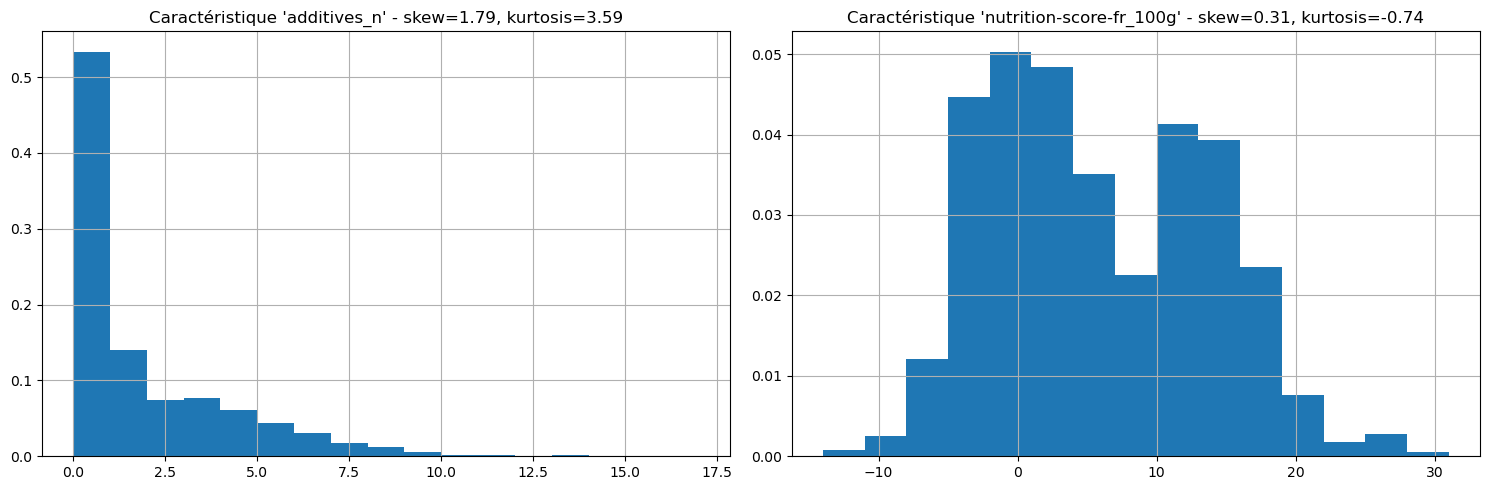

In [5]:
# 'Describe' des variables numériques
print("* Analyse des variables de la famille 'vitamins'")
display(data[vitamins].describe())
print("* Analyse des variables de la famille 'minerals'")
display(data[minerals].describe())
print("* Analyse des variables de la famille 'toMinimize'")
display(data[toMinimize].describe())
print("* Analyse des variables de la famille 'additives_n' et 'nutrition-score-fr_100g'")
display(data[['additives_n', 'nutrition-score-fr_100g']].describe())


# Histogramme de 'additives_n'
fig = plt.figure(figsize=(15,5))
gs = GridSpec(nrows=1, ncols=2)
fig.add_subplot(gs[0, 0])
data['additives_n'].hist(density=True, bins=17)
plt.title("Caractéristique 'additives_n'")
plt.title("Caractéristique 'additives_n' - skew={:.2f}, kurtosis={:.2f}".format(data['additives_n'].skew(),
                                                                                data['additives_n'].kurtosis()))
# Histogramme de 'nutrition-score-fr_100g'
fig.add_subplot(gs[0, 1])
data['nutrition-score-fr_100g'].hist(density=True, bins=15)
plt.title("Caractéristique 'nutrition-score-fr_100g' - skew={:.2f}, kurtosis={:.2f}".format(data['nutrition-score-fr_100g'].skew(),
                                                                                            data['nutrition-score-fr_100g'].kurtosis()))
plt.tight_layout()
plt.show()

<a id="analyse_uni_cat"></a>
#### Caractéristiques catégorielles
- Caractéristique 'palm' : environ 80% des produits ne contiennent pas d'huile palme contre un peu plus de 10% qui en contiennent, et presque 10% pour lesquels cette caractéristique est inconnue.
&nbsp;
- Caractéristiques 'pnns_groups_1' et 'pnns_groups_2' :
  - La catégorie la plus importante concerne les produits laitiers ('pnns_groups_1') comprennant en particulier le lait, les yaourts et le fromage ('pnns_groups_2') ;
  - en seconde position vient les boissons, dont les jus de fruit constituent la sous-catégorie la plus importante.
  - en troisième position, les céréales et pommes de terre, dont les céréales pour le petit déjeuner constituent la sous-catégorie la plus importante ;
  - en quatrième position, les snacks sucrés, dont les biscuits, chocolat et confiserie ;
  - en cinquième position, les huiles et, marginalement, les sauces ;
  - en sixième position, les fruits et légumes.
&nbsp;
- Caractéristique 'nutrition_grade_fr' :
  - une répartition équivalente entre les notes A, C et D ;
  - la note E arrive en dernier, avec un nombre de produits concernés moitié moins important que pour les produits A, C et D: cela renforce l'interrogation sur le fait que les produits avec un mauvais nutri-score ne communiqueraient pas cette information.
&nbsp;
- Caractéristique 'brands' :
  - 1380 marques pour 4041 produits : avec une marque pour 3 produits en moyenne, il y a un grand nombre de marques ;
  - sur les 10 marques les plus fréquentes, une sur deux appartient à la grande distribution.
&nbsp;
- Caractéristique 'stores' :
  - 413 enseignes pour 4041 produits, soit en moyenne 10 produits par magasin ;
  - les 8 premières enseignes appartiennent logiquement à la grande distribution.

*[retour sommaire](#sommaire)*

In [6]:
# Variables catégorielles - Describe
display(data[cat_features].describe())

,palm,pnns_groups_1,pnns_groups_2,nutrition_grade_fr,brands,stores
count,4041,4041,4041,4041,4041,4041
unique,3,9,31,5,1381,414
top,False,Milk and dairy products,Milk and yogurt,a,U,***unknown***
freq,3179,1162,619,992,130,1398


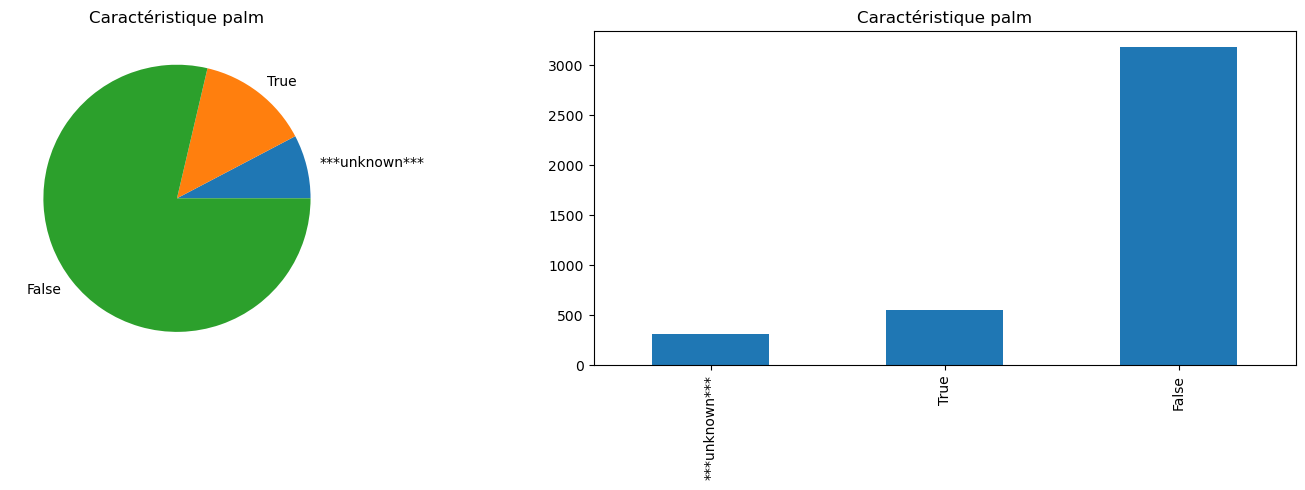

In [7]:
# Caractéristique 'palm'
fct.univar_cat(data, 'palm')

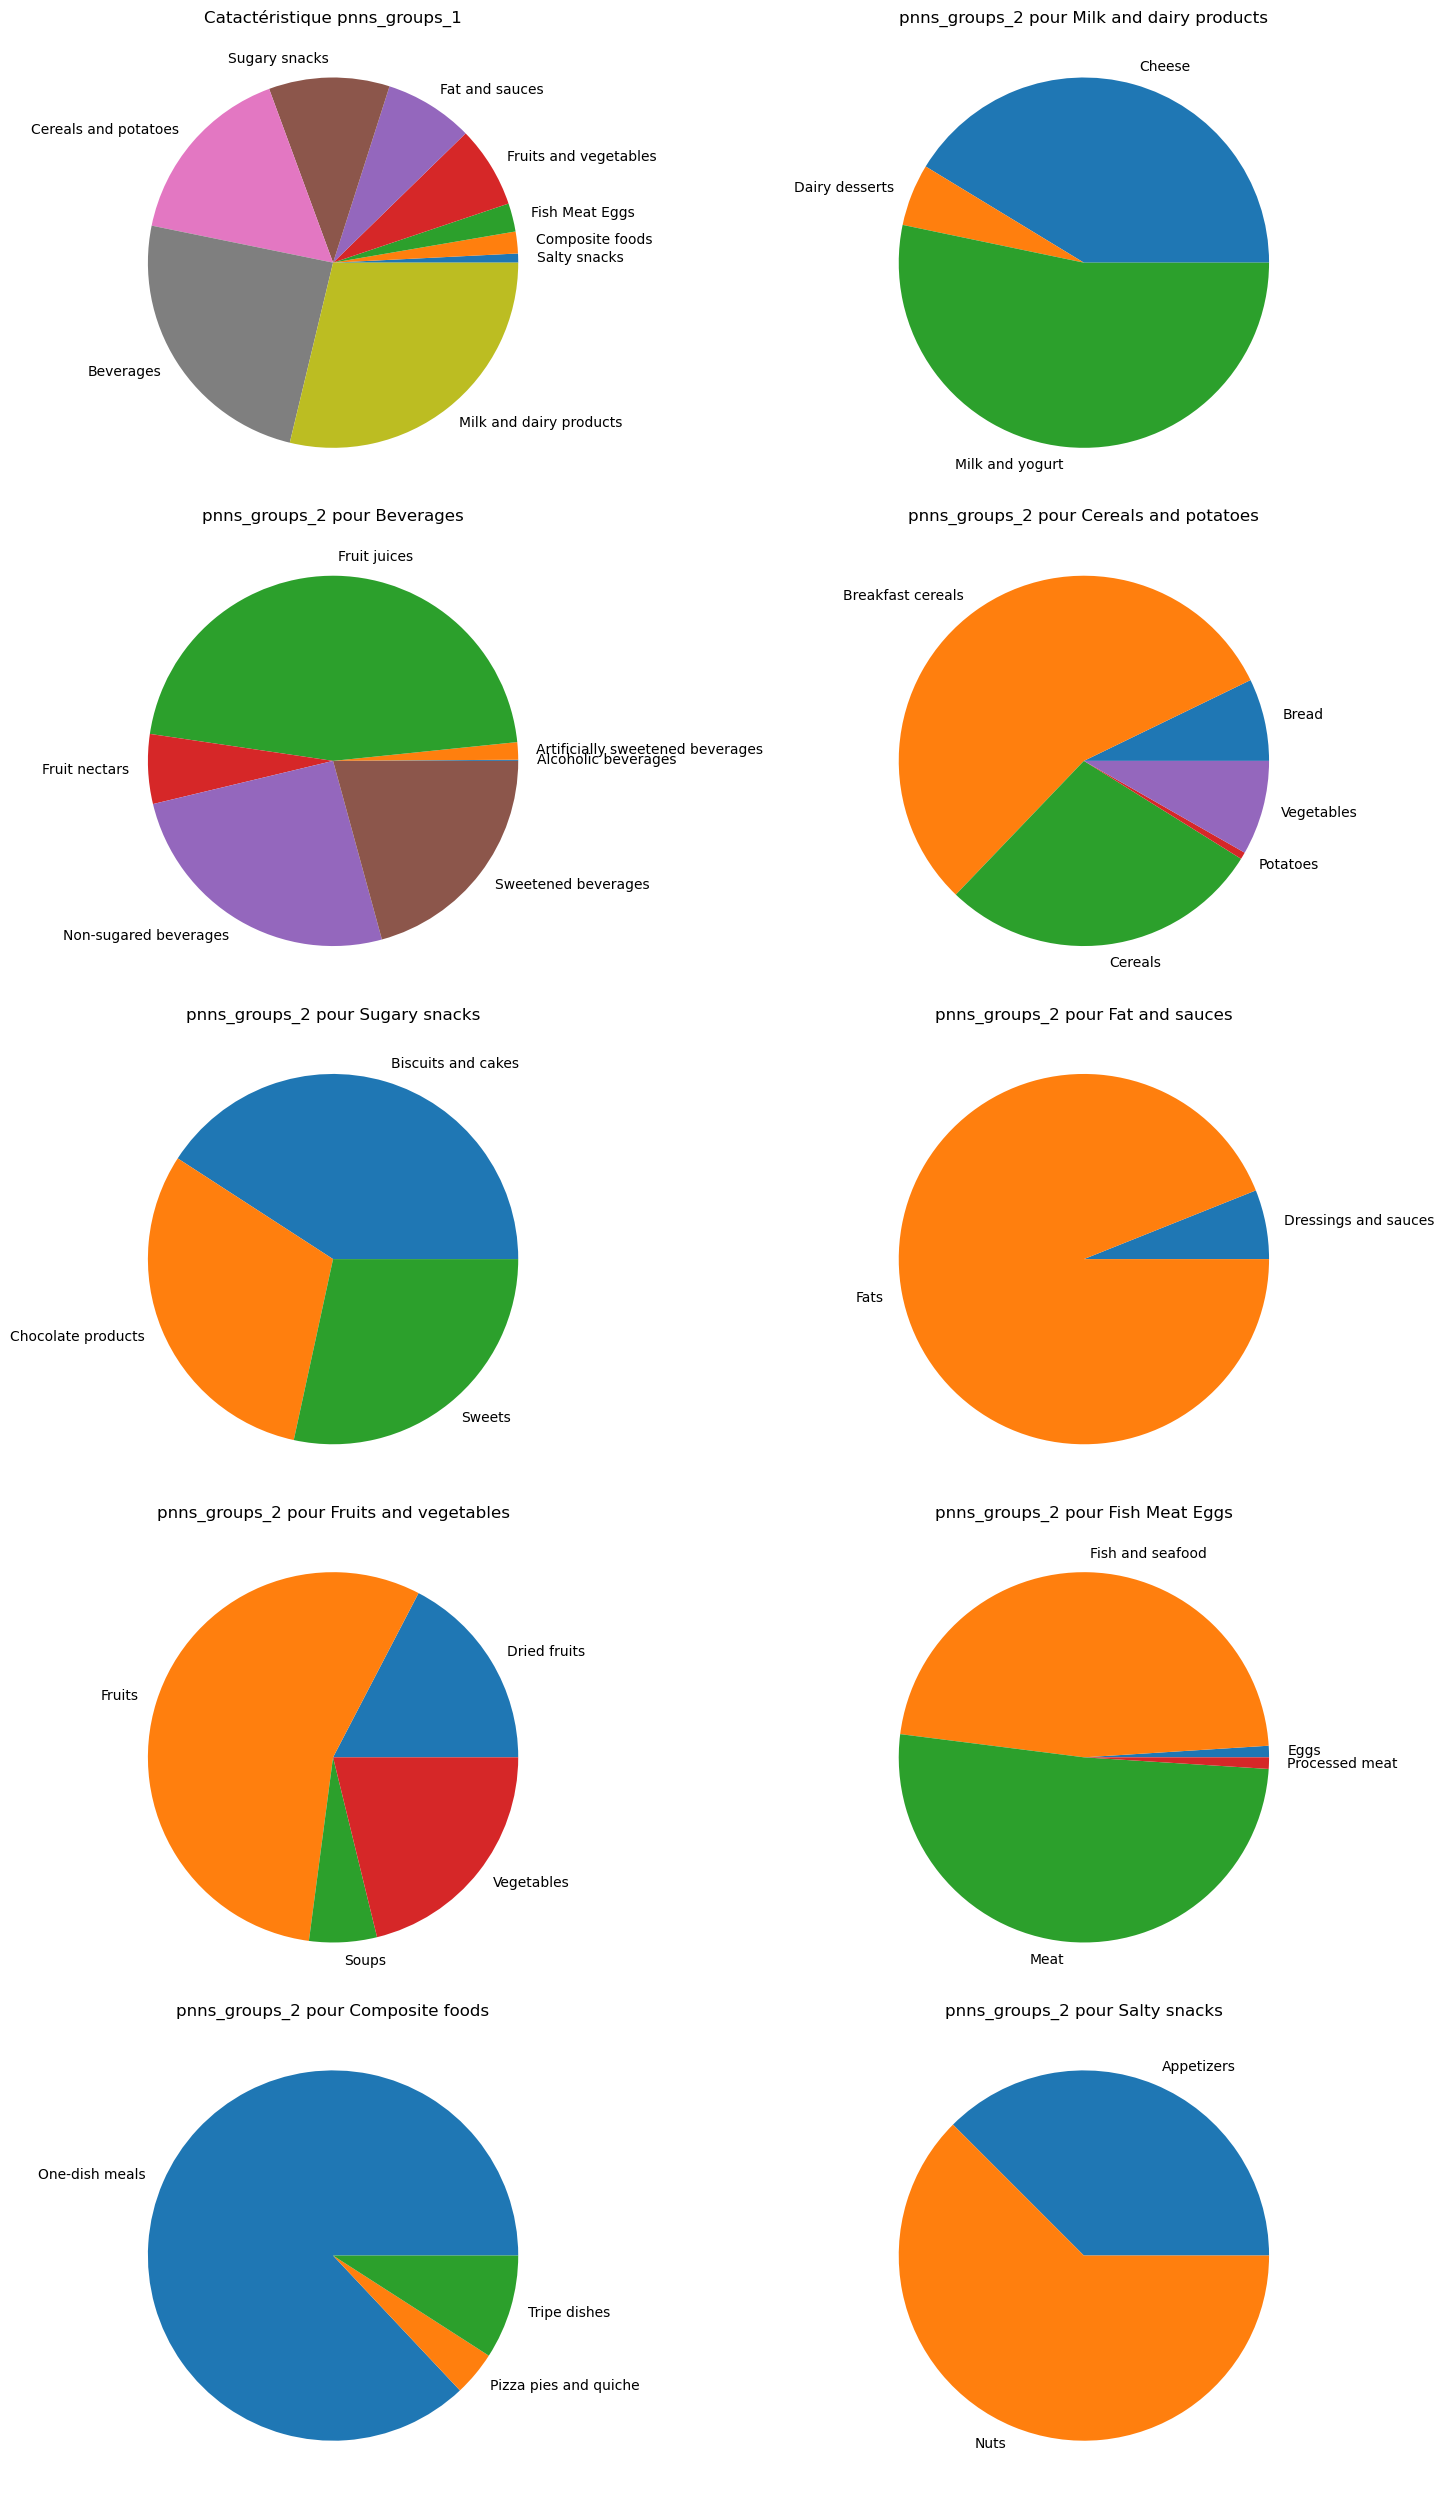

In [8]:
# Caractéristiques 'pnns_groups_1' et 'pnns_groups_2' combinées listées par double ordre décroissant d'occurrence
fct.univar_combo_cat(data, 'pnns_groups_1', 'pnns_groups_2')

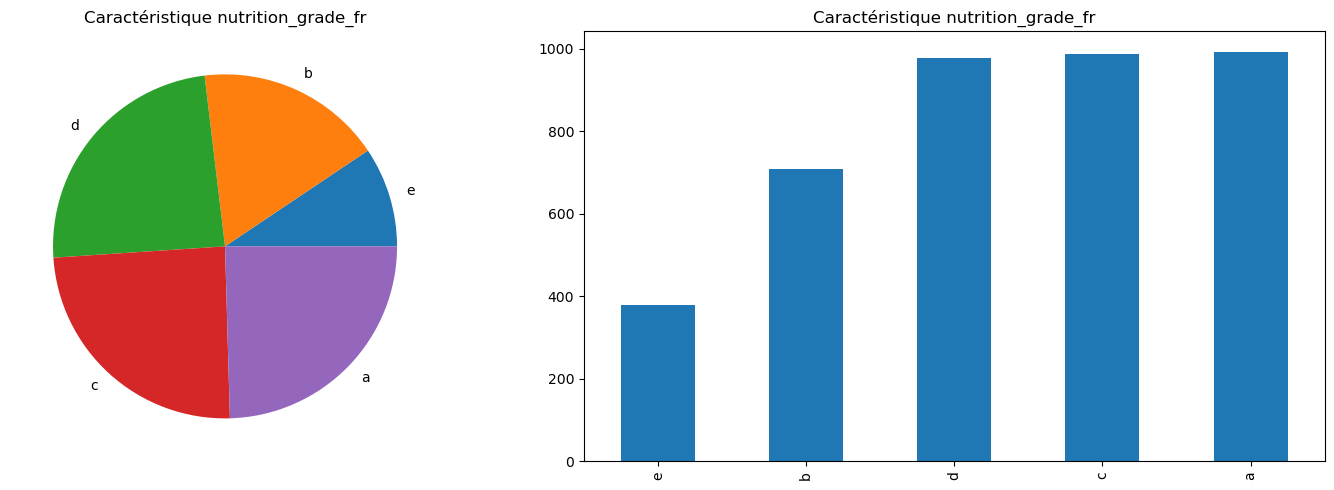

In [9]:
# Caractéristique 'nutrition_grade_fr'
fct.univar_cat(data, 'nutrition_grade_fr')

 1381 catégories de brands pour 4041 produits
 --> Affichage des 10 premières catégories


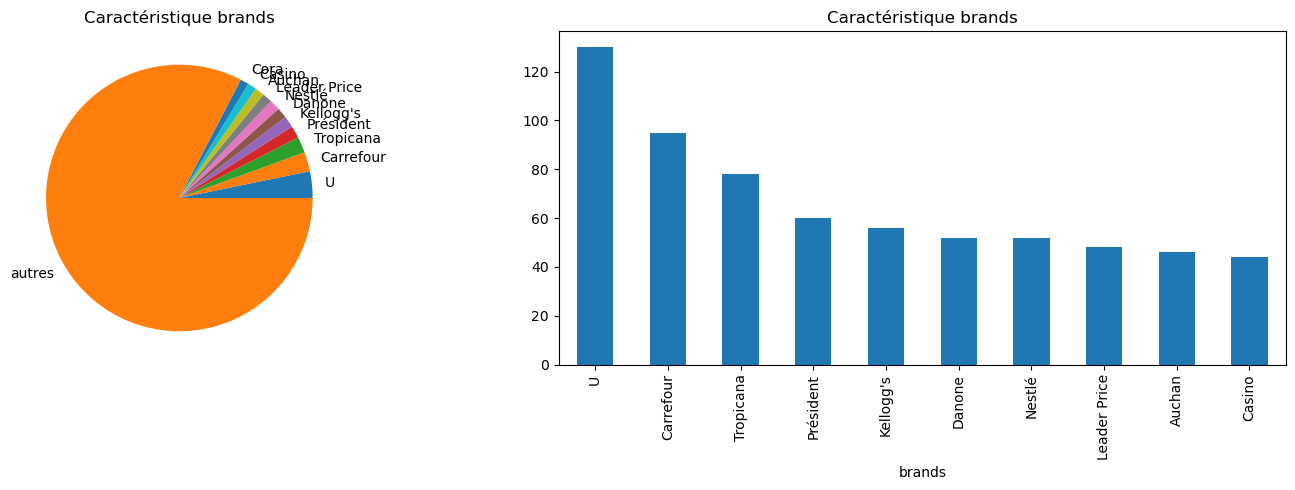

In [10]:
# Caractéristique 'brands'
fct.univar_big_cat(data, 'brands', 11)

 414 catégories de stores pour 4041 produits
 --> Affichage des 7 premières catégories


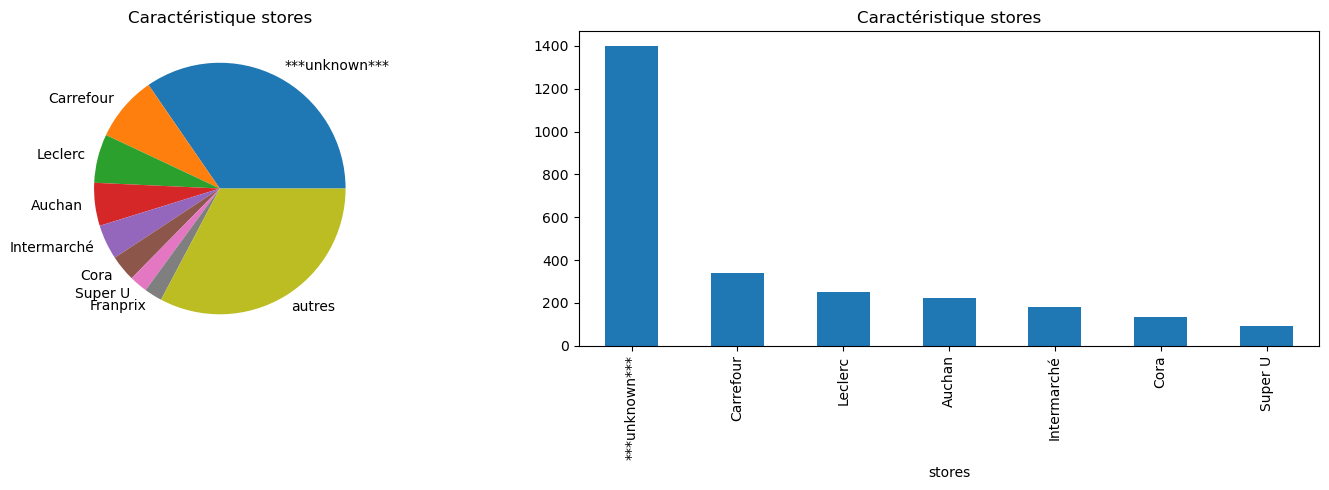

In [11]:
# Caractéristique 'stores'
fct.univar_big_cat(data, 'stores', 8)

<a id="analyse_bi"></a>
### Analyse bi-variée
L'analyse bi-variée consiste en l'analyse des variables 2 à 2:
- variables numériques entre elles ;
- combinaisons variable catégorielle avec variable numérique.

Dans cette analyse, nous visons à mettre en évidence des corrélations entre variables et, le cas échéant, examiner plus avant ces corrélations par le tracé de graphiques appropriés.

*[retour sommaire](#sommaire)*

<a id="analyse_bi_num"></a>
#### Caractéristiques numériques entre elles
L'évaluation des corrélations s'effectue en s'appuyant sur le coefficient de corrélation de Pearson. Pour cela, nous le calculons pour chaque couple de variables et fixons un seuil minimum pour mettre en évidence d'éventuelles corrélations. Avec un seuil de coefficient de corrélation de 0.55, 5 corrélations potentielles sont identifiées parmi lesquelles :
- un fort coefficient de corrélation concernant les vitamines B2 et PP (B3) dans la nourriture ;
- de même pour les vitamines B2 et B5 (acide pantothénique) ;
- des corrélations non probantes pour les autres paires de variables.

&nbsp;
Dans la lignée de l'estimation du Nutri-grade effectué dans le Notebook 1, nous examinons ses éventuelles corrélations avec les variables de la famille 'toMinimize':
- comme déjà vu ci-dessus, le rapport de corrélation η² montre que la caractéristique saturated-fat_100g est celle de plus forte influence sur la note ;
- de manière générale, l'augmentation de sel, graisses saturées, graisses trans et sucre dégrade la note de nutri-score ;
- le sucre est le nutriment ayant le moins d'impact sur la note.

Cet examen montre les faibles corrélations linéaires entre ces variables et conforte en conséquence le recours au k-NN pour l'estimation du nutri-grade.


*[retour sommaire](#sommaire)*

In [12]:
# Recherche de corrélation entre les variables numériques
exportfile = dossierData + '\\' + 'cor_table'
fct.cor_table(data, num_features, thresshold=0.55, XLexport=exportfile)

* Recherche de corrélations potentielle entre les caractéristiques numériques , coefficient de Pearson > 0.55 :
  -> Liste des 5 paires de caractéristiques à examiner :


[['vitamin-b2_100g', 'vitamin-pp_100g'],
 ['vitamin-b2_100g', 'pantothenic-acid_100g'],
 ['vitamin-pp_100g', 'pantothenic-acid_100g'],
 ['bicarbonate_100g', 'silica_100g'],
 ['saturated-fat_100g', 'nutrition-score-fr_100g']]

  -> Table de corrélation :


,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b2_100g,silica_100g,bicarbonate_100g,nutrition-score-fr_100g,saturated-fat_100g
vitamin-pp_100g,0.00,0.63,0.87,-0.02,-0.02,0.14,-0.11
pantothenic-acid_100g,0.63,0.00,0.60,-0.01,-0.01,0.11,-0.08
vitamin-b2_100g,0.87,0.60,0.00,-0.02,-0.02,0.13,-0.09
silica_100g,-0.02,-0.01,-0.02,0.00,0.59,-0.06,-0.03
bicarbonate_100g,-0.02,-0.01,-0.02,0.59,0.00,-0.07,-0.04
nutrition-score-fr_100g,0.14,0.11,0.13,-0.06,-0.07,0.00,0.60
saturated-fat_100g,-0.11,-0.08,-0.09,-0.03,-0.04,0.60,0.00


Tracé des caractéristiques par paires potentiellement corrélées


C:\Users\EricPaul\AppData\Local\Temp\ipykernel_22076\186700706.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


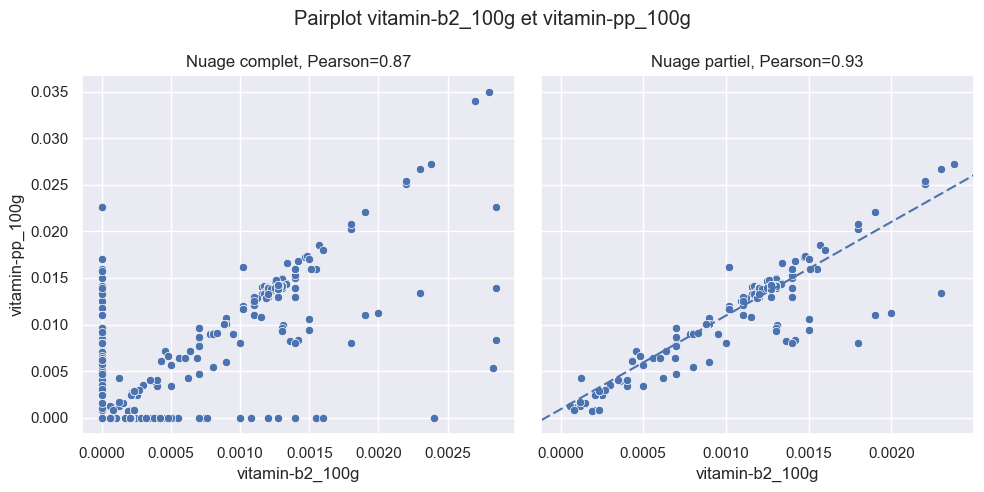

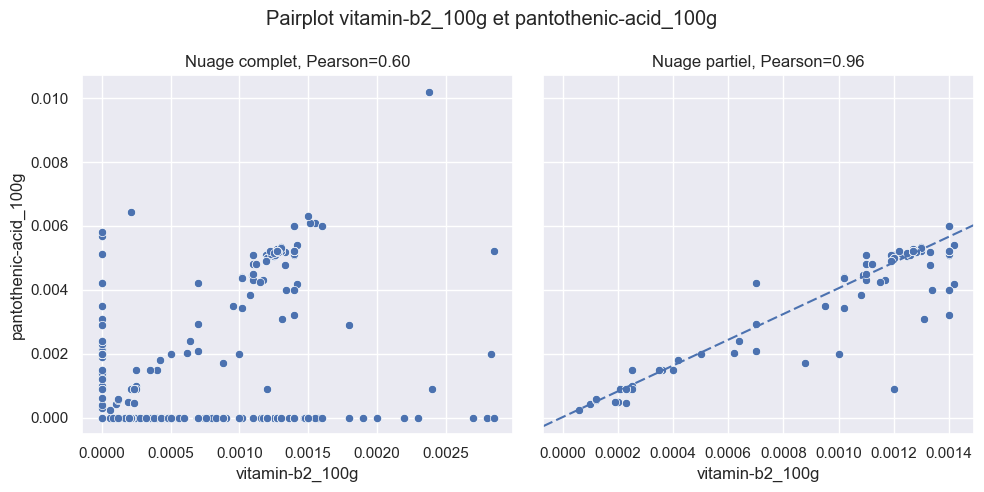

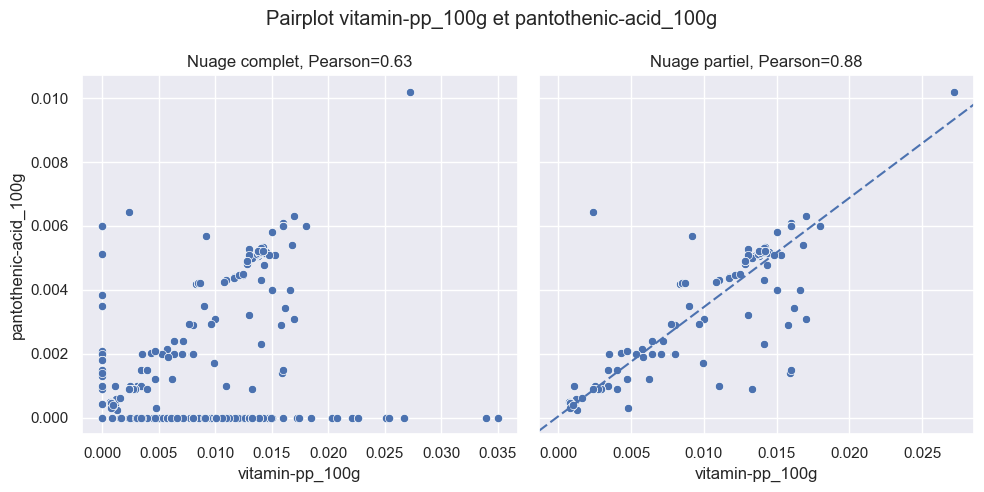

Nuage complet, Pearson=0.59


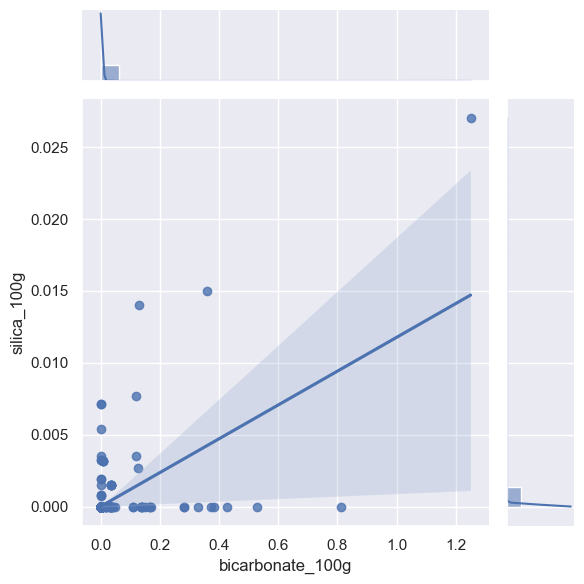

Nuage complet, Pearson=0.60


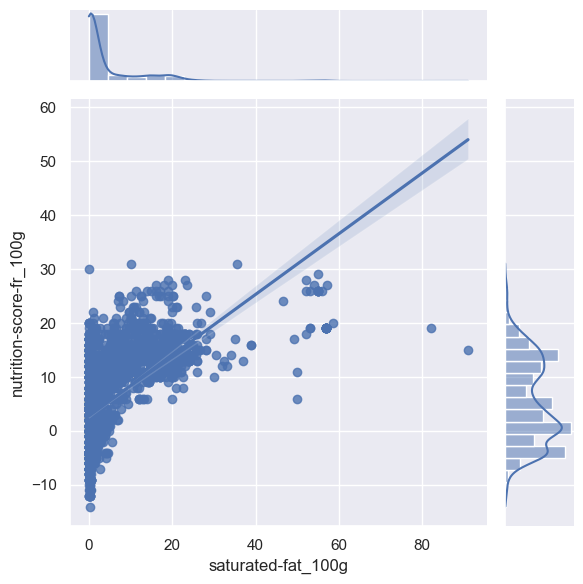

In [13]:
# Tracés par paires
# Fixation des paramètres graphiques
sns.set()
plt.style.use('seaborn-whitegrid')
#sns.set_style("whitegrid")
sns.set_theme()
# Tracé graphique par paire de variable
#for pair in list_pair_cor:
#    fct.pair_plot(data, pair)
print("Tracé des caractéristiques par paires potentiellement corrélées")
fct.pair_plot(data, ['vitamin-b2_100g', 'vitamin-pp_100g'], exclude_x=0, exclude_y=0, xmax=0.0025)
fct.pair_plot(data, ['vitamin-b2_100g', 'pantothenic-acid_100g'], exclude_x=0, exclude_y=0, xmax=0.0015, ymax=0.006)
fct.pair_plot(data, ['vitamin-pp_100g', 'pantothenic-acid_100g'], exclude_x=0, exclude_y=0)
fct.pair_plot(data, ['bicarbonate_100g', 'silica_100g'])
fct.pair_plot(data, ['saturated-fat_100g', 'nutrition-score-fr_100g'])

Variables intervenant dans le calcul du nutri-score


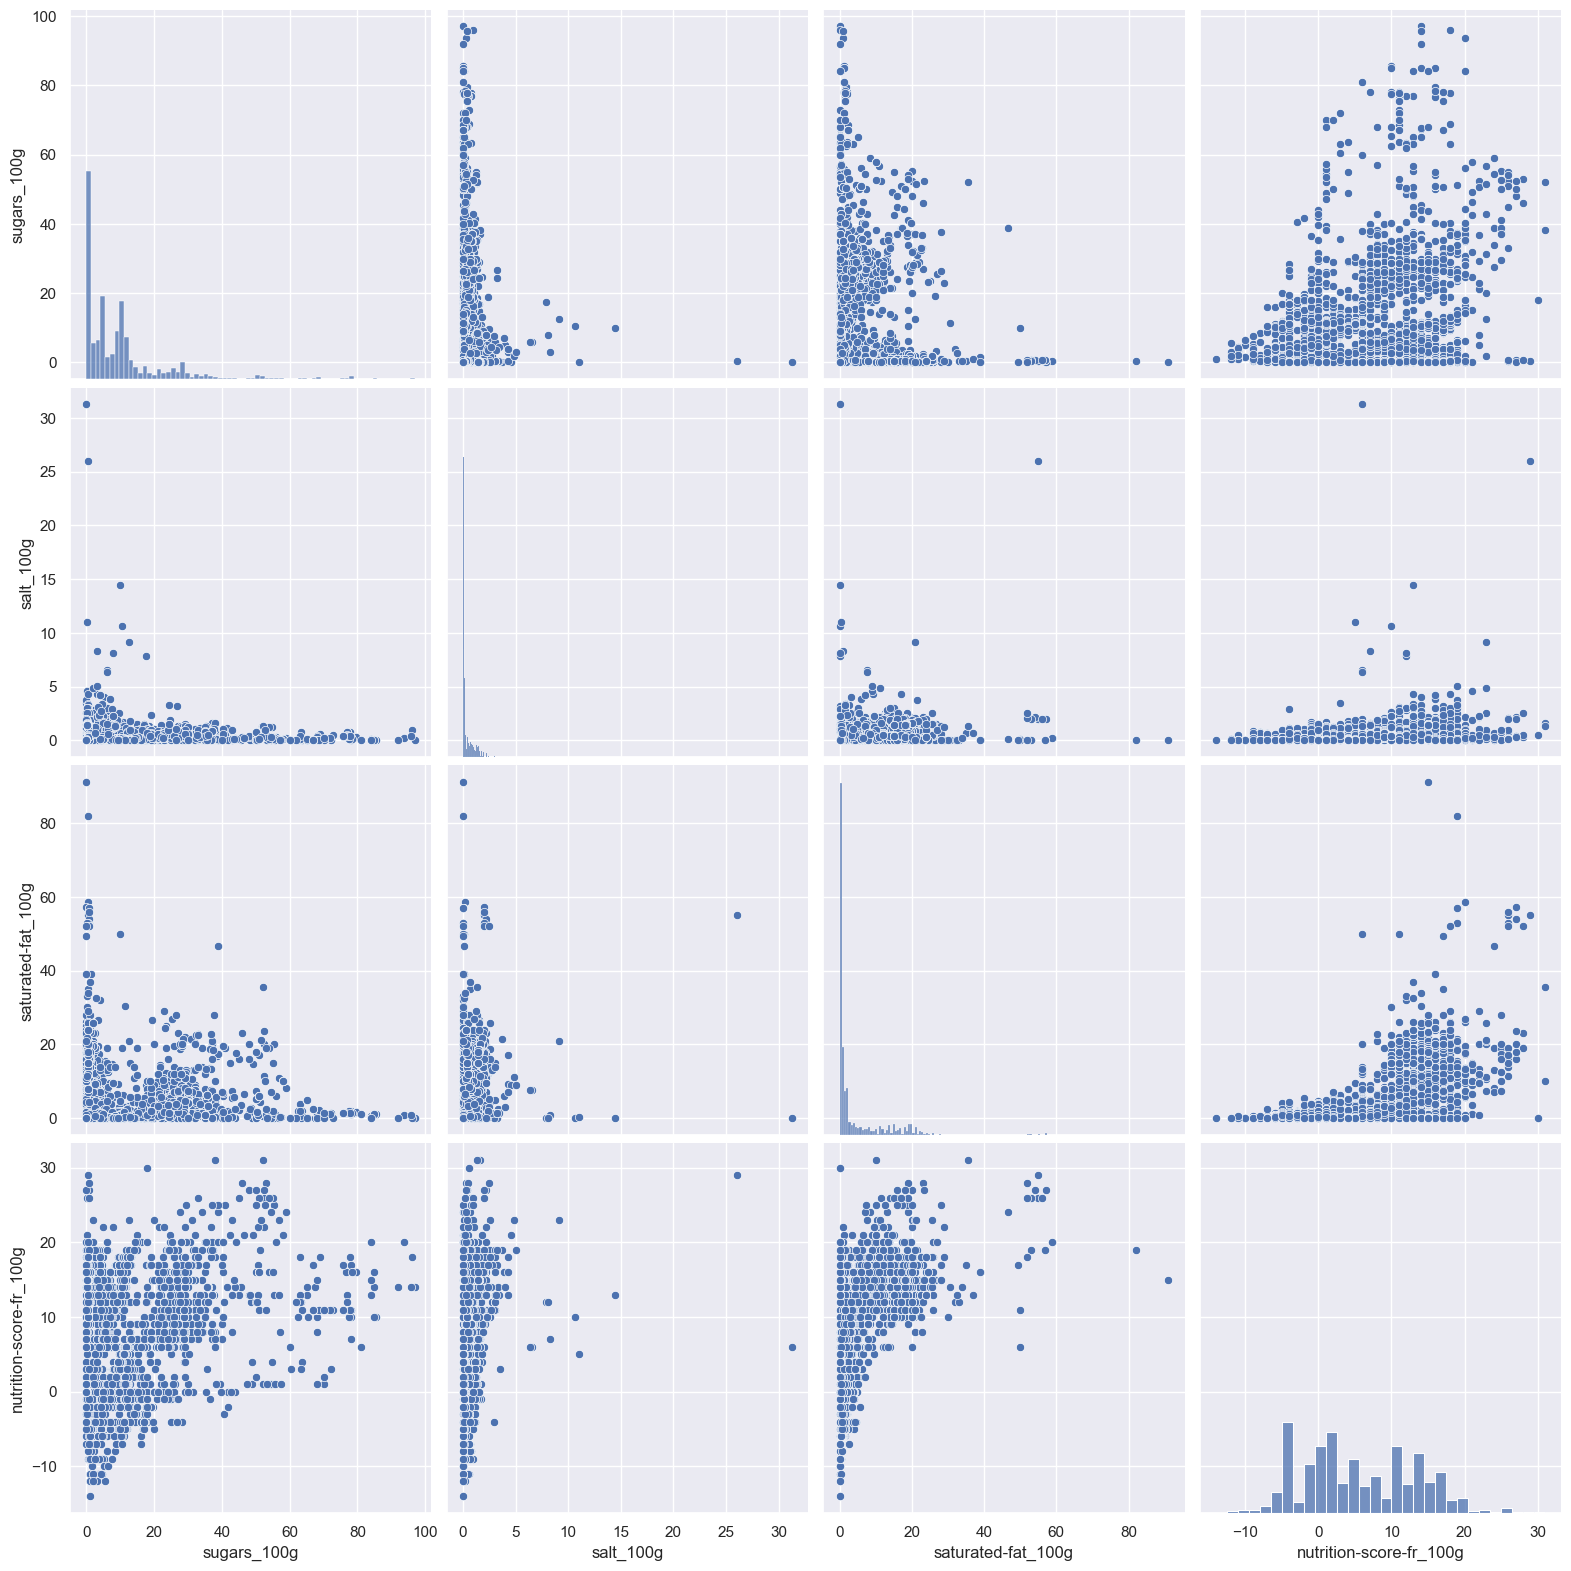

In [14]:
# Examen des nuages de points avec les variables intervenant dans le calcul du nutri-score
print("Variables intervenant dans le calcul du nutri-score")
sns.pairplot(data=data[['sugars_100g', 'salt_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g']], height=4)

<a id="analyse_bi_num_cat"></a>
#### Caractéristiques mixtes catégorielles / numériques
La recherche de corrélations s'effectue en s'appuyant sur le rapport de corrélation η². Pour cela, ce rapport est calculé pour toutes les paires de variables et un seuil est fixé pour investiguer plus avant par le tracé de graphe boxplot :
- les caractéristiques catégorielles contenant de nombreuses catégories (brands, stores) sont naturellement corrélées avec les autres variables, car elles sont associées à un petit nombre de données numériques (comme le montrent les 2 exemples de graphique) ;
  &nbsp;
- avec le seuil de rapport de corrélation de η²=0.5, 7 paires de corrélations potentielles sont identifiées (diminuer le seuil de η² introduit seulement des corrélations avec 'pnns_groups_1', ce qui est redondant avec celles déjà identifiées concernant 'pnns_groups_2') ;
  &nbsp;
- la forte corrélation entre 'nutrition_grade_fr' et 'nutrition-score-fr_100g' est vérifiée, et renforcée par la segmentation des produits en boisson ou solide (cf box plots) ;
  &nbsp;
- conformément au calcul du nutri-score, les catégories de produits sont relativement corrélées avec 'nutrition-score-fr_100g' et donnent dans l'ordre, de la meilleure à moins bonne note : fruits et légumes, poissons-viandes-œufs, nourriture composée, céréales et pdt, produits laitiers, boissons, snacks salés, huiles et sauces, snacks sucrés ;
  &nbsp;
- les catégories de produits sont potentiellement corrélées avec les caractéristiques 'vitamin-b2_100g', 'vitamin-pp_100g', 'calcium_100g', 'saturated-fat_100g', et 'sugars_100g' :
  - les vitamines B2 et PP, ainsi que le sucre, sont particulièrement présentes dans les céréales pour petit déjeuner ;
  - les graisses saturées sont particulièrement présentes dans les huiles et sauces, le fromage et les produits chocolatés, ce qui parait normal ;
  - le sucre est présent dans la plupart des produits, plus particulièrement dans les snacks sucrés, les fruits secs, les gateaux, les céréales petit déjeuner, les fruits et les boissons ;
  - le calcium est particulièrement présent dans le fromage.
&nbsp;
- Nutri-grade avec  avec famille toMinimize:
  - comme déjà vu ci-dessus, le rapport de corrélation η² montre que la caractéristique saturated-fat_100g est celle de plus forte influence sur la note (η²=0.3) ;
  - on ne peut pas conclure au-delà.


*[retour sommaire](#sommaire)*

In [15]:
# Table des corrélations avec η²
exportfile = dossierData + '\\' + 'eta_table'
fct.eta_table(data, cat_features, num_features, thresshold=0.5)

* Recherche de corrélations potentielle entre caractéristiques catégorielles et numériques , coefficient η² > 0.5 :
  -> Caractéristiques exclues de l'analyse car comportant trop (> 40 , soit >1.0%) de catégories (situation d'overfitting):


['brands', 'stores']

,additives_n,vitamin-a_100g,beta-carotene_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,vitamin-c_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,bicarbonate_100g,calcium_100g,chloride_100g,chromium_100g,copper_100g,fluoride_100g,iodine_100g,iron_100g,magnesium_100g,manganese_100g,phosphorus_100g,potassium_100g,selenium_100g,silica_100g,zinc_100g,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,nutrition-score-fr_100g
brands,0.65,0.58,0.57,0.73,0.68,0.68,0.55,0.64,0.39,0.58,1.00,0.86,0.73,0.64,0.03,0.72,0.68,0.99,1.00,0.95,0.60,0.47,0.62,0.69,0.62,0.60,0.65,0.35,0.65,0.50,0.76,0.70,0.74,0.74,0.72
stores,0.13,0.03,0.02,0.33,0.13,0.14,0.13,0.12,0.16,0.20,0.02,0.59,0.03,0.09,0.02,0.11,0.12,0.03,0.00,0.05,0.15,0.39,0.15,0.14,0.01,0.11,0.12,0.17,0.02,0.18,0.08,0.13,0.06,0.15,0.13


  -> Liste des 7 paires de caractéristiques à examiner :


[['nutrition_grade_fr', 'nutrition-score-fr_100g'],
 ['pnns_groups_2', 'calcium_100g'],
 ['pnns_groups_2', 'nutrition-score-fr_100g'],
 ['pnns_groups_2', 'saturated-fat_100g'],
 ['pnns_groups_2', 'sugars_100g'],
 ['pnns_groups_2', 'vitamin-b2_100g'],
 ['pnns_groups_2', 'vitamin-pp_100g']]


  -> Table de corrélation :


,vitamin-pp_100g,nutrition-score-fr_100g,sugars_100g,vitamin-b2_100g,calcium_100g,saturated-fat_100g
pnns_groups_2,0.56,0.54,0.55,0.58,0.53,0.53
nutrition_grade_fr,0.04,0.88,0.08,0.04,0.11,0.29


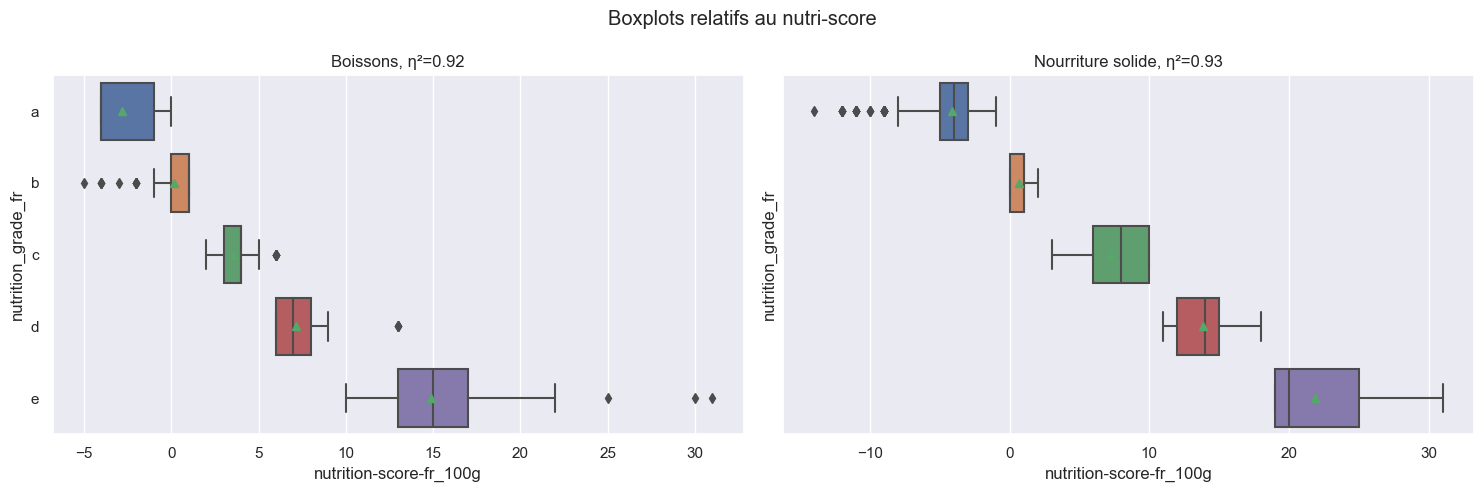

Nuage complet pour les 10 catégories du graphique, η²=0.28


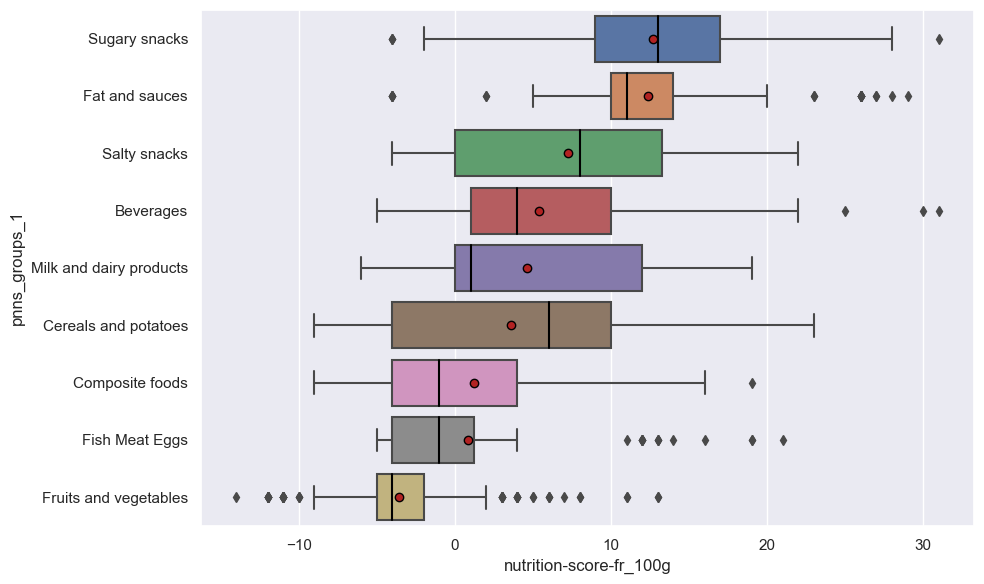

In [16]:
# Examen des corrélations sur les couples identifiés
# Nutriscore et Nutrigrade en fonction de la catégorie de produit
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
suptitle = "Boxplots relatifs au nutri-score"
fig.suptitle(suptitle)
# Préparations des dataframes pour les calculs et tracés
dfb = pd.DataFrame([])
dfs = pd.DataFrame([])
dfb['nutrition-score-fr_100g'] = data.loc[data['pnns_groups_1']=='Beverages', 'nutrition-score-fr_100g']
dfs['nutrition-score-fr_100g'] = data.loc[data['pnns_groups_1']!='Beverages', 'nutrition-score-fr_100g']
dfb['nutrition_grade_fr'] = data.loc[data['pnns_groups_1']=='Beverages', 'nutrition_grade_fr']
dfs['nutrition_grade_fr'] = data.loc[data['pnns_groups_1']!='Beverages', 'nutrition_grade_fr']
# Tracé du boxplot pour les boissons
eta_sqr = fct.eta_squared(dfb['nutrition_grade_fr'], dfb['nutrition-score-fr_100g'])
sns.boxplot(ax=axes[0], x='nutrition-score-fr_100g', y='nutrition_grade_fr', data=dfb, showmeans=True)
title = "Boissons, η²=" + f"{eta_sqr:.2f}"
axes[0].set_title(title)
# Tracé du boxplot pour la nourriture solide
eta_sqr_ve = fct.eta_squared(dfs['nutrition_grade_fr'], dfs['nutrition-score-fr_100g'])
sns.boxplot(ax=axes[1], x='nutrition-score-fr_100g', y='nutrition_grade_fr', data=dfs, showmeans=True)
title = "Nourriture solide, η²=" + f"{eta_sqr_ve:.2f}"
axes[1].set_title(title)
# Affichage des graphiques
plt.tight_layout()
plt.show()

# Nutriscore en fonction de la catégorie de produit
fct.pair_boxplot(data, ['pnns_groups_1', 'nutrition-score-fr_100g'], nb_cat=10)

Nuage complet pour les 10 catégories du graphique, η²=0.45


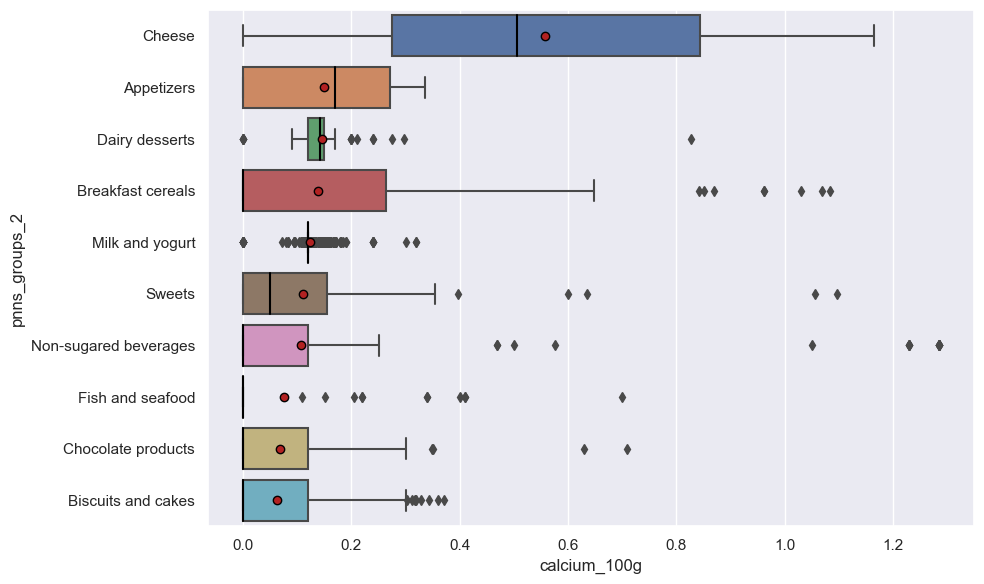

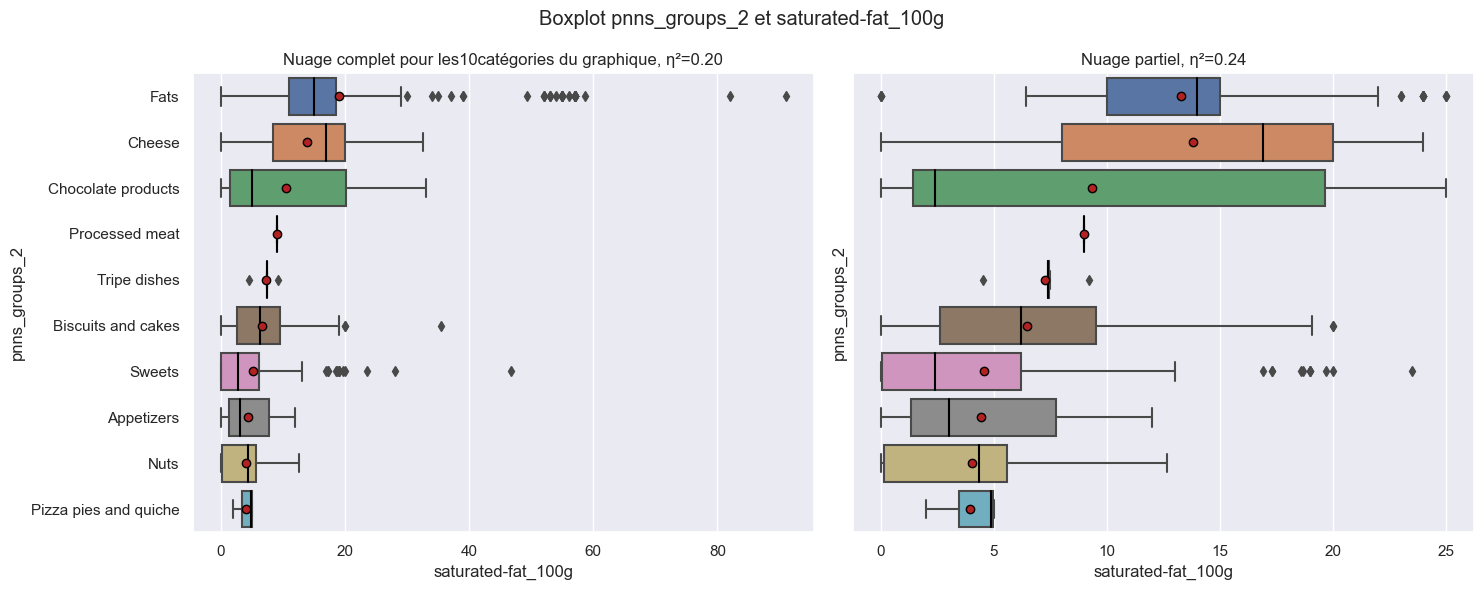

Nuage complet pour les 18 catégories du graphique, η²=0.47


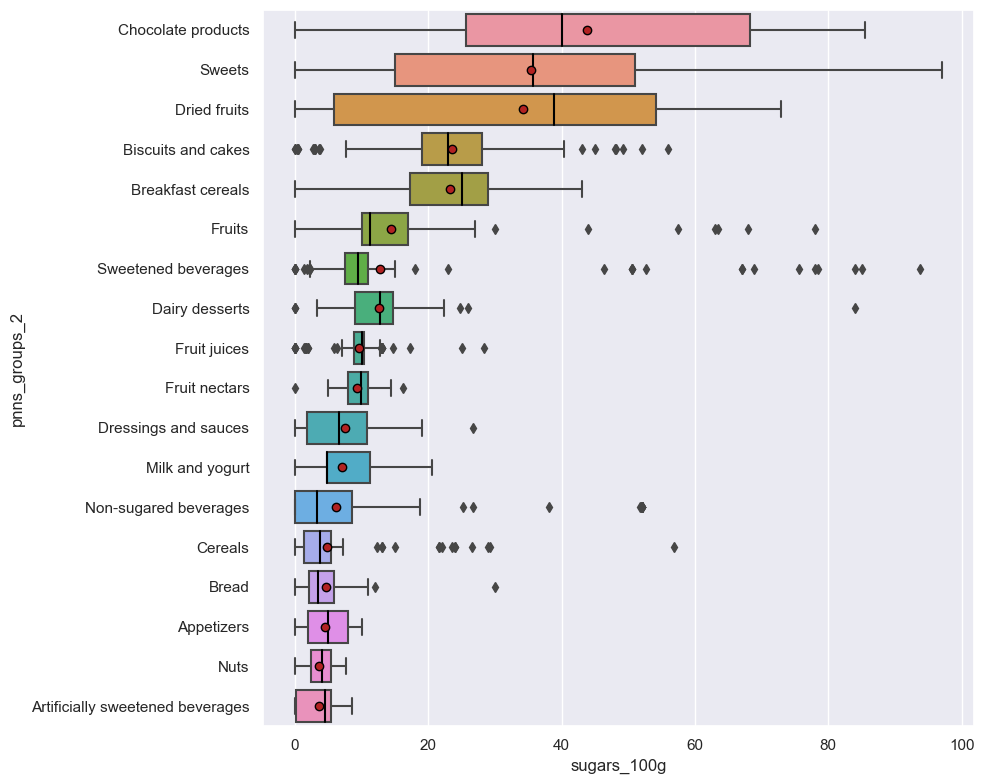

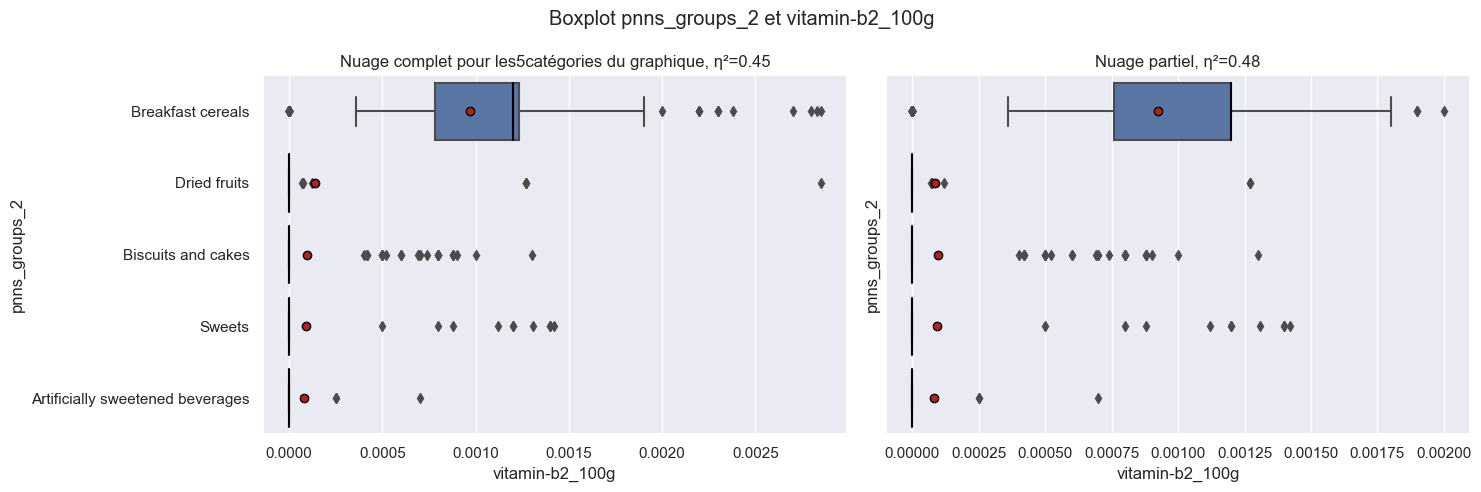

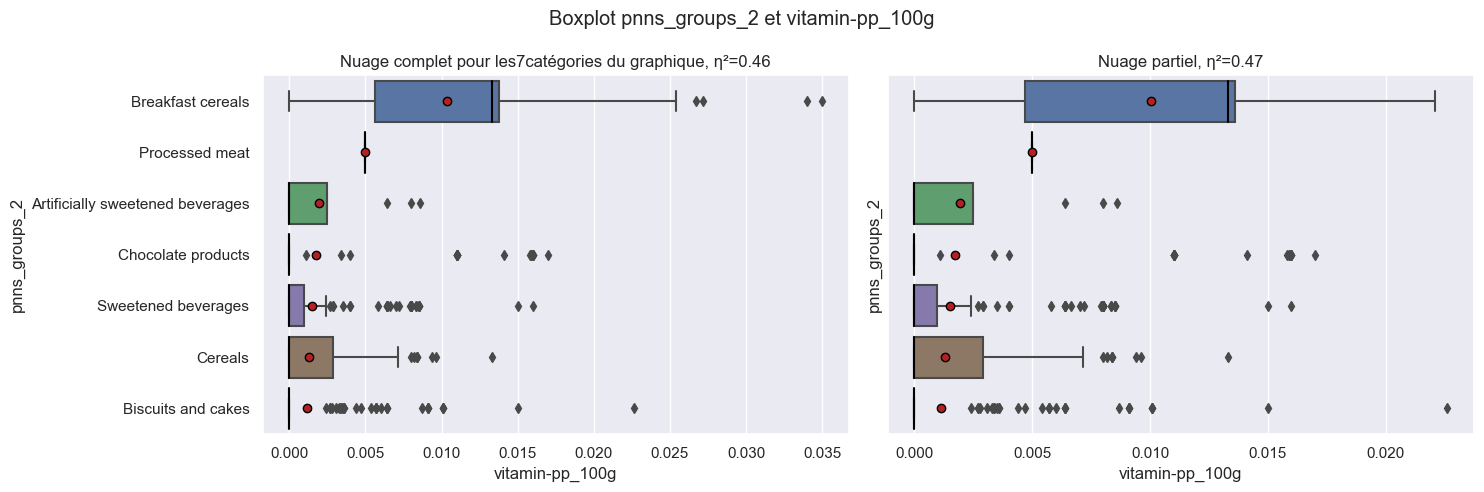

In [17]:
# Examen des corrélations avec 'pnns_groups_2'
#fct.pair_boxplot(data, pair, nb_cat=5, exclude_x=0, xmin=0, xmax=100)
fct.pair_boxplot(data, ['pnns_groups_2', 'calcium_100g'], nb_cat=10)
fct.pair_boxplot(data, ['pnns_groups_2', 'saturated-fat_100g'], nb_cat=10, xmax=25)
fct.pair_boxplot(data, ['pnns_groups_2', 'sugars_100g'], nb_cat=18)
fct.pair_boxplot(data, ['pnns_groups_2', 'vitamin-b2_100g'], xmax=0.002)
fct.pair_boxplot(data, ['pnns_groups_2', 'vitamin-pp_100g'], nb_cat=7, xmax=0.025)

Nuage complet pour les 9 catégories du graphique, η²=0.12


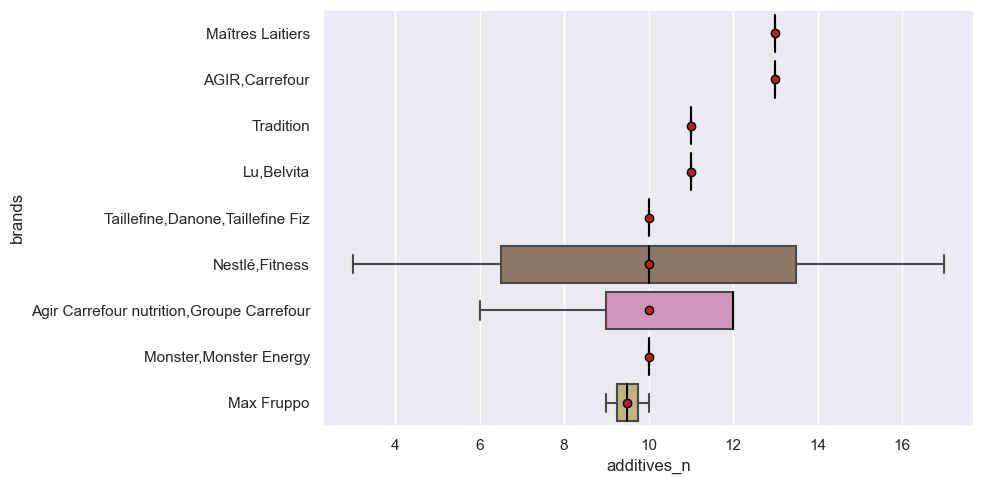

In [18]:
# Examen des corrélations avec 'brands'
fct.pair_boxplot(data, ['brands', 'additives_n'], nb_cat=9)

Nuage complet pour les 5 catégories du graphique, η²=1.00


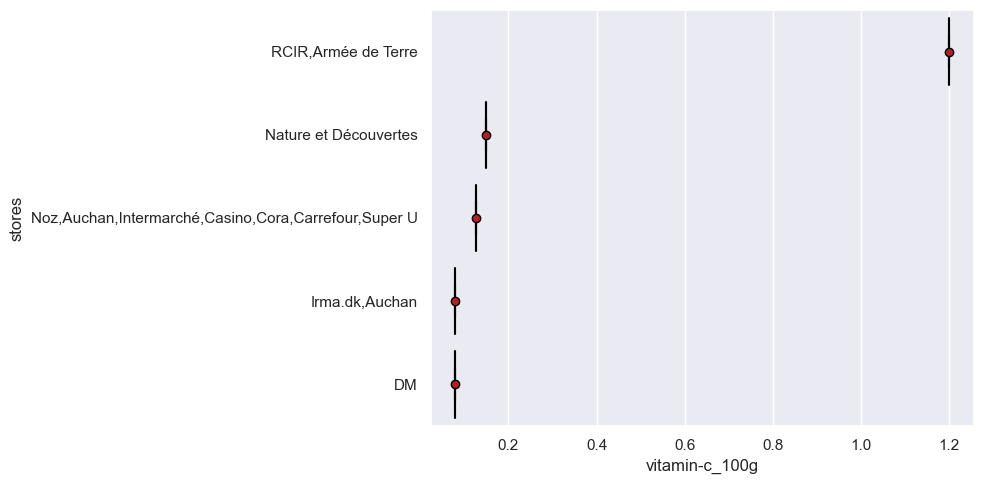

In [19]:
# Examen des corrélations avec 'stores'
fct.pair_boxplot(data, ['stores', 'vitamin-c_100g'])

Analyse bi-variée avec nutrition_grade_fr


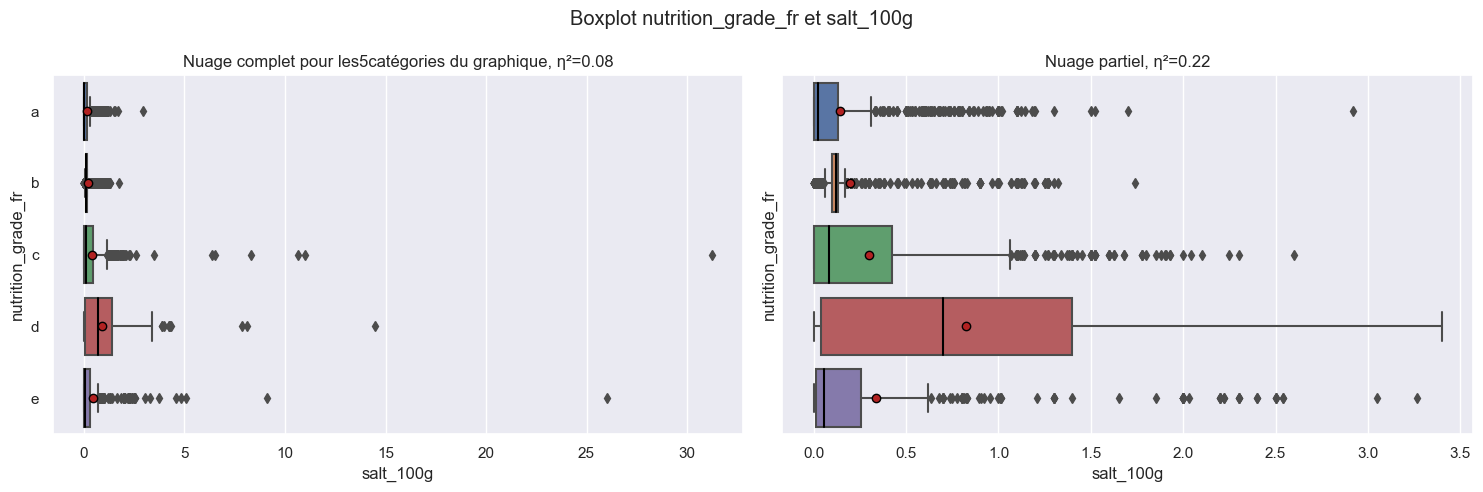

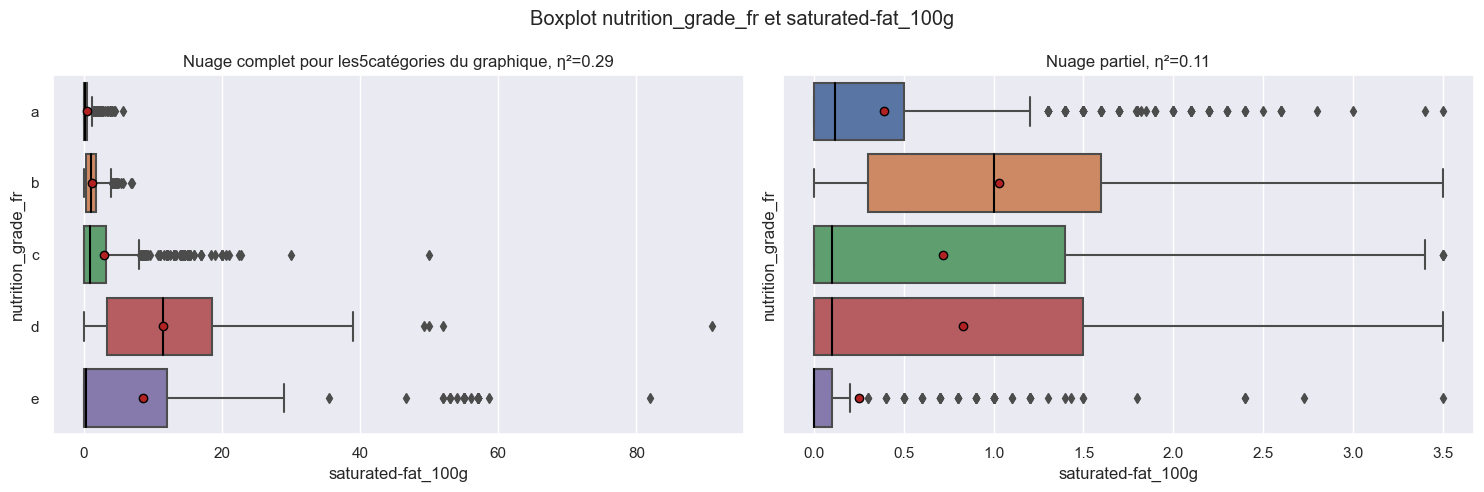

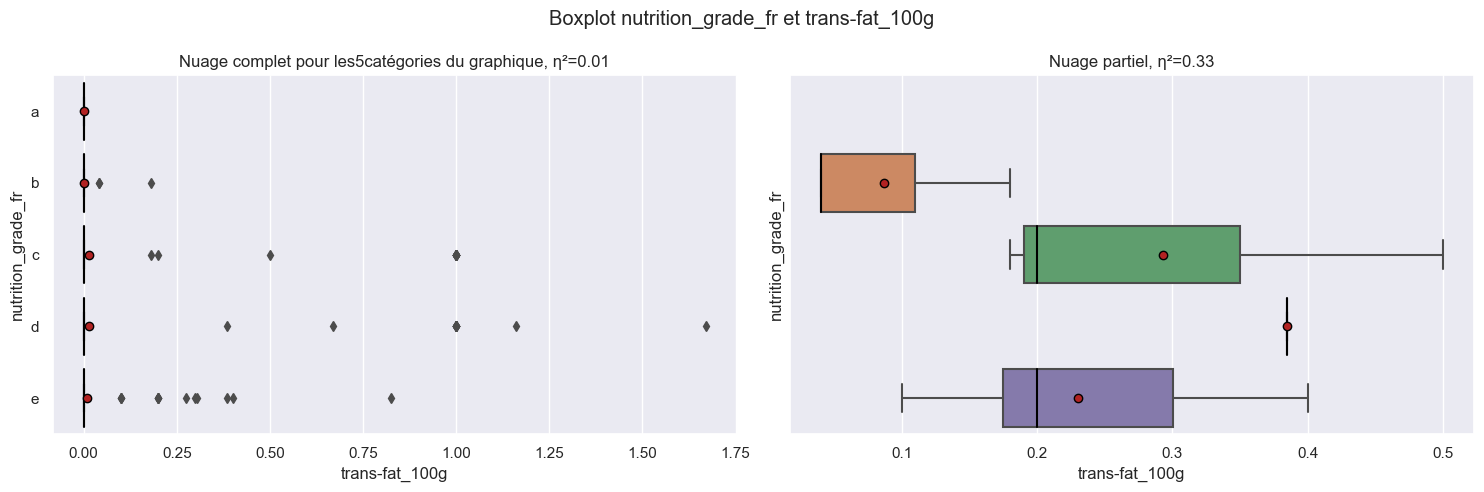

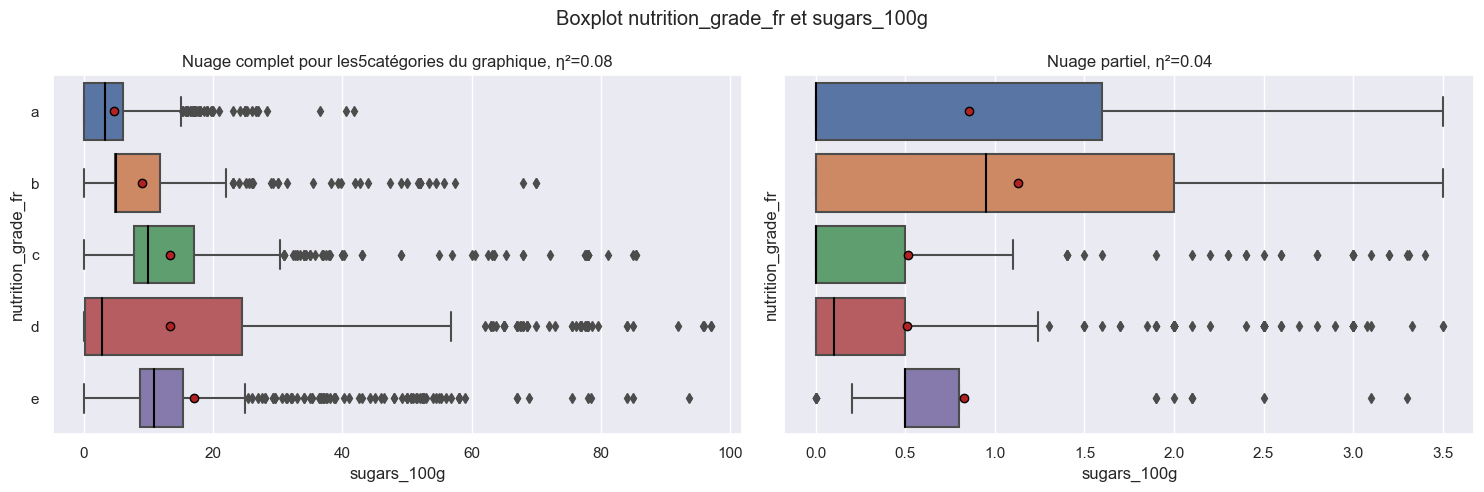

In [20]:
# Corrélations avec les caractéristiques numériques intervenant dans le calcul de nutrition_grade_fr
list_pair_nutrigrade = [['nutrition_grade_fr', 'salt_100g'], ['nutrition_grade_fr', 'saturated-fat_100g'],
                        ['nutrition_grade_fr', 'trans-fat_100g'], ['nutrition_grade_fr', 'sugars_100g']]
print("Analyse bi-variée avec nutrition_grade_fr")
#for pair in list_pair_nutrigrade:
#    fct.pair_boxplot(data, pair)
fct.pair_boxplot(data, ['nutrition_grade_fr', 'salt_100g'], cat_ordering='alpha', xmax=3.5)
fct.pair_boxplot(data, ['nutrition_grade_fr', 'saturated-fat_100g'], cat_ordering='alpha', xmax=3.5)
fct.pair_boxplot(data, ['nutrition_grade_fr', 'trans-fat_100g'], cat_ordering='alpha', exclude_x=0, xmax=0.5)
fct.pair_boxplot(data, ['nutrition_grade_fr', 'sugars_100g'], cat_ordering='alpha', xmax=3.5)

<a id="analyse_multi"></a>
## Partie 5 - Notebook d'analyse exploratoire - Analyse multi-variée
Cette partie est consacrée à l'analyse en composantes principales des variables numériques et à la réalisation d'une analyse de variance.

*[retour sommaire](#sommaire)*

<a id="acp"></a>
### Analyse en composantes principales (ACP)
L'analyse s'effectue à partir de l'ensemble de variables numériques pour se raffiner progressivement :
- 35 variables, 4041 individus, 9 composantes (pour aller jusqu'au critère de Kaiser) ;
- réduction aux 22 variables (vecteurs projetés > 0.3) et 8 composantes ;
- sélection de 2 couples d'axes d'inertie : un plan pour les vitamines et un autre pour les minéraux.

Plans factoriels interessants :
- plan F1-F5 représente principalement des vitamines : vitamines B (B2, B3, B5, B9) selon F1 et (A, ß-carotène, B1, D) selon F5 :
  - les caractéristiques des vitamines B2, B3, B5, B9 sont effectivement corrélées (cf matrice des corrélations) ;
  - les caractéristiques des vitamines A et D sont effectivement corrélées, mais pas avec les 2 autres, et ß-carotène est faiblement corrélés avec B1 (0.27).
  &nbsp;
- plan (F2, F3) représente principalement des sels minéraux : minéraux (bicarbonate, chlorure, fluorure, silicium) selon F2 et (potassium, magnésium, manganèse, phosphore, selenium) selon F3 :
  - Les caractéristiques bicarbonate, chlorure, fluorure et silicium sont corrélées entre elles, sauf le fluorure avec le silicium (0.15).
  - Les caractéristiques potassium, magnésium, manganèse, phosphore, selenium sont faiblement corrélées entre elles.
&nbsp;
- Par ailleurs, l'axe d'inertie F4 représente principalement le nutri-score et les graisses saturées, dont on sait déjà qu'ils sont corrélés.


S'agissant de la projection des individus, il y a une forte concentration autour de 0 et pour améliorer la lisibilité des sorties graphiques du Notebook, nous utilisons une échelle logarithmique.
La projection des individus (produits) sur ces plans ne permet cependant pas de détecter des groupes intéressants.

Nous examinons en conséquence des groupes restraints de données correspondant aux associations de vitamines et minéraux que nous souhaitons privilégier (cf [la section ci-dessous sur l'application](#appli)):


*[retour sommaire](#sommaire)*

Analyse en Composantes principales (ACP)
  - 35 variables
  - 4041 individus (produits)

 - n_components_ :  9
 - explained_variance_ : [3.608 2.46  2.229 2.097 1.602 1.514 1.462 1.193 1.157]
 - explained_variance_ratio_ : [0.103 0.07  0.064 0.06  0.046 0.043 0.042 0.034 0.033]
 - singular_values_ : [120.733  99.69   94.888  92.043  80.462  78.204  76.842  69.436  68.36 ]
 - components_ : (9, 35)


* Eboulis des valeurs propres


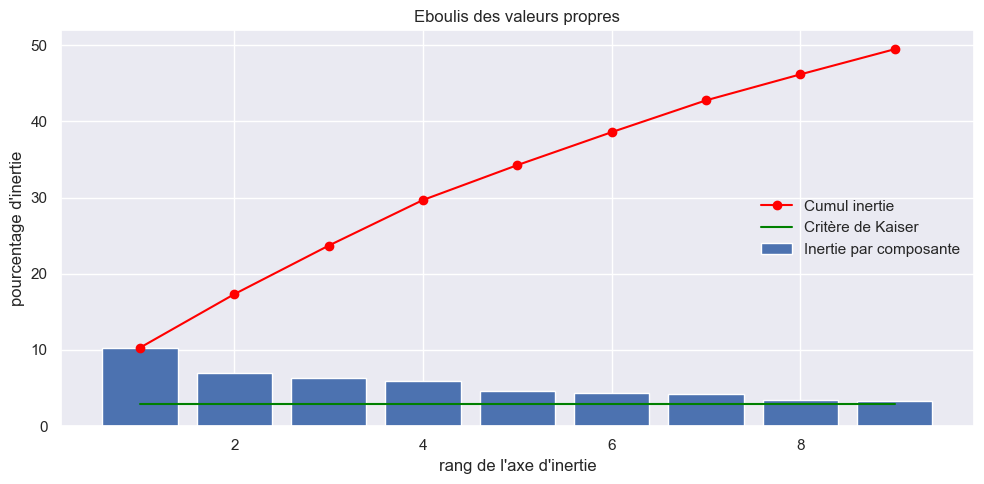

* Cercle(s) des corrélations et projections des individus dans les plans factoriels


In [21]:
# Choix du nombre de composantes à calculer
n_comp = 9

# Sélection des caractéristiques à prendre en compte dans l'ACP et préparation des données
pca_features = num_features
data_pca = data[pca_features].copy()
X = data_pca.values
names = np.array(data_pca.index) # pour les labels de p_labels
pca_labels = np.array([s.replace("_100g", "") for s in pca_features]) # pour les labels de c_labels


print(fct.Fore.LIGHTGREEN_EX + "Analyse en Composantes principales (ACP)")
print("  -", data_pca.shape[1], 'variables')
print("  -", data_pca.shape[0], 'individus (produits)\n' + fct.Style.RESET_ALL)

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

np.set_printoptions(precision=3)
print(" - n_components_ : ", pca.n_components_)
print(" - explained_variance_ :", pca.explained_variance_)
print(" - explained_variance_ratio_ :", pca.explained_variance_ratio_)
print(" - singular_values_ :", pca.singular_values_)
print(" - components_ :", np.shape(pca.components_))
print('\n')

# Eboulis des valeurs propres
print(fct.Fore.LIGHTBLUE_EX + "* Eboulis des valeurs propres" + fct.Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(fct.Fore.LIGHTBLUE_EX + "* Cercle(s) des corrélations et projections des individus dans les plans factoriels" + fct.Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X_scaled)

In [22]:
# Pour afficher les graphiques dans des fenêtres séparées
%matplotlib qt

# Liste des plans pour l'affichage graphique
plans = [[i,i+1] for i in range(1, n_comp, 2)]
if n_comp % 2 != 0:
    plans.append([1, n_comp])

# Définition des échelles de tracé (projection des individus) et tracé des graphiques
scale = 'linear', 'linear'
for plan in plans:
    filename = "Cercle_correlation_&_projection_p1_" + str(plan[0]) + "-" + str(plan[1]) + ".png"
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale, p_labels = None,
                           c_labels=pca_labels, c_label_rotation=0, c_lims=None, filter=0.3,
                           save = dossierFigures + '\\' + filename)
    plt.show()

  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p1_1-2.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p1_3-4.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p1_5-6.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p1_7-8.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p1_1-9.png


Analyse en Composantes principales (ACP)
  - 22 variables
  - 4041 individus (produits)

 - n_components_ :  8
 - explained_variance_ : [3.031 2.261 2.065 1.881 1.51  1.481 1.364 1.093]
 - explained_variance_ratio_ : [0.138 0.103 0.094 0.085 0.069 0.067 0.062 0.05 ]
 - singular_values_ : [110.655  95.582  91.347  87.177  78.113  77.345  74.221  66.457]
 - components_ : (8, 22)


* Eboulis des valeurs propres


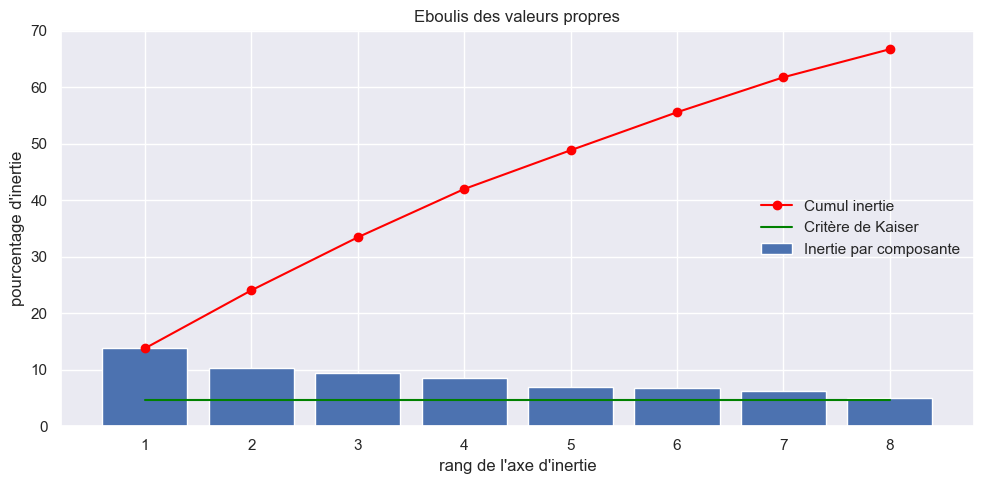

* Cercle(s) des corrélations et projections des individus dans les plans factoriels


In [23]:
# Retour à l'affichage des graphiques dans le notebook
%matplotlib inline

# Choix du nombre de composantes à calculer
n_comp = 8

# Sélection des caractéristiques à prendre en compte dans l'ACP et préparation des données
pca_features = ['vitamin-a_100g', 'beta-carotene_100g', 'vitamin-b1_100g', 'vitamin-b2_100g','vitamin-pp_100g',
                'pantothenic-acid_100g', 'vitamin-b9_100g', 'vitamin-c_100g', 'vitamin-d_100g',
                'bicarbonate_100g', 'calcium_100g', 'chloride_100g', 'fluoride_100g', 'magnesium_100g',
                'manganese_100g', 'phosphorus_100g', 'potassium_100g', 'selenium_100g', 'silica_100g',
                'saturated-fat_100g','sugars_100g',
                'nutrition-score-fr_100g']
data_pca = data[pca_features].copy()
X = data_pca.values
names = np.array(data_pca.index) # pour les labels de p_labels
pca_labels = np.array([s.replace("_100g", "") for s in pca_features]) # pour les labels de c_labels


print(fct.Fore.LIGHTGREEN_EX + "Analyse en Composantes principales (ACP)")
print("  -", data_pca.shape[1], 'variables')
print("  -", data_pca.shape[0], 'individus (produits)\n' + fct.Style.RESET_ALL)

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

np.set_printoptions(precision=3)
print(" - n_components_ : ", pca.n_components_)
print(" - explained_variance_ :", pca.explained_variance_)
print(" - explained_variance_ratio_ :", pca.explained_variance_ratio_)
print(" - singular_values_ :", pca.singular_values_)
print(" - components_ :", np.shape(pca.components_))
print('\n')

# Eboulis des valeurs propres
print(fct.Fore.LIGHTBLUE_EX + "* Eboulis des valeurs propres" + fct.Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(fct.Fore.LIGHTBLUE_EX + "* Cercle(s) des corrélations et projections des individus dans les plans factoriels" + fct.Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X_scaled)

In [24]:
# Pour afficher les graphiques dans des fenêtres séparées
%matplotlib qt

# Liste des plans pour l'affichage graphique
plans = [[i,i+1] for i in range(1, n_comp, 2)]
if n_comp % 2 != 0:
    plans.append([1, n_comp])

# Définition des échelles de tracé (projection des individus) et tracé des graphiques
scale = 'linear', 'linear'
for plan in plans:
    filename = "Cercle_correlation_&_projection_p2_" + str(plan[0]) + "-" + str(plan[1]) + ".png"
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale, p_labels = None,
                           c_labels=pca_labels, c_label_rotation=0, c_lims=None, filter=0.3,
                           save = dossierFigures + '\\' + filename)
    plt.show()

  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p2_1-2.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p2_3-4.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p2_5-6.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p2_7-8.png


  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p3_1-5.png
  --> Sauvegarde du tracé dans: .\PSante_06_figures\Cercle_correlation_&_projection_p3_2-3.png


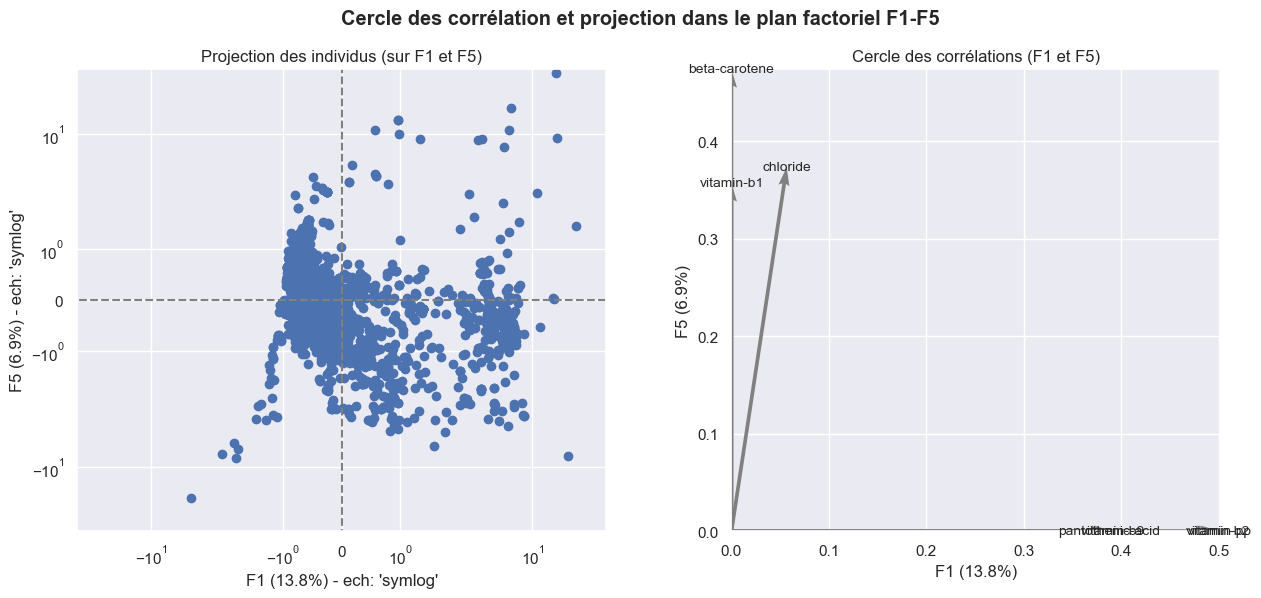

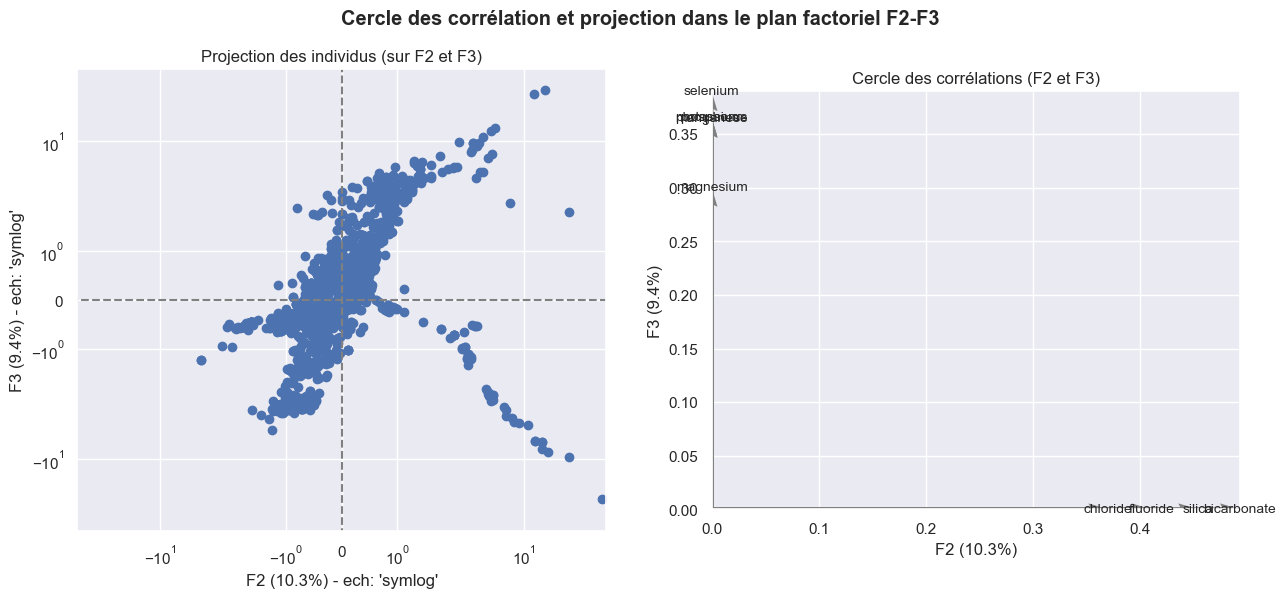

In [25]:
# Retour à l'affichage des graphiques dans le notebook
%matplotlib inline

# Définition des échelles de tracé (projection des individus) et des plans à afficher
scale = 'symlog', 'symlog'
plans=[[1,5], [2,3]]
for plan in plans:
    filename = "Cercle_correlation_&_projection_p3_" + str(plan[0]) + "-" + str(plan[1]) + ".png"
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale, p_labels = None,
                           c_labels=pca_labels, c_label_rotation=0, c_lims=None, filter=0.3,
                           save = dossierFigures + '\\' + filename)
plt.show()

<a id="acp_appli"></a>
### Analyse en composantes principales relative à l'application envisagée (ACP)
Nous examinons ici des groupes restraints de données correspondant à plusieurs des associations de vitamines et minéraux que nous souhaitons privilégier (cf [la section ci-dessous sur l'application](#appli)):
- **Fer et vitamine C** : l'ACP montre qu'il y a un nombre restraint de produits (87) qui comprennent à la fois du fer et de la vitamine C ; de plus, plus le taux de fer est élevé et plus le score nutritionnel se dégrade (augmente) ; il faut donc privilégier les produits à forte teneur en vitamine C et teneur modérée en fer.
&nbsp;
- **Magnésium et vitamines B** : l'ACP montre qu'il y a de nombreux produits contenant à la fois du magnésium et des vitamines B, à l'exception de la vitamine B12 qui est anti-corrélée avec le magnésium ; par ailleurs, le nutri-score se dégrade (augmente) avec l'augmentation du taux de magnésium ; il faut donc privilégier les produits à forte teneur en vitamine B et teneur modérée en magnésium.
&nbsp;
- **Calcium et vitamine D** : l'ACP montre un nombre significatif de produit contenant à la fois du calcium et de la vitamine D ; par ailleurs, le nutri-score se dégrade (augmente) avec l'augmentation du taux de calcium ; il faut donc privilégier les produits à forte teneur en vitamine D et teneur modérée en calcium.
&nbsp;


*[retour sommaire](#sommaire)*

Analyse en Composantes principales (ACP)
  - 3 variables
  - 4041 individus (produits)

 - n_components_ :  2
 - explained_variance_ : [1.061 1.003]
 - explained_variance_ratio_ : [0.354 0.334]
 - singular_values_ : [65.475 63.656]
 - components_ : (2, 3)


* Eboulis des valeurs propres


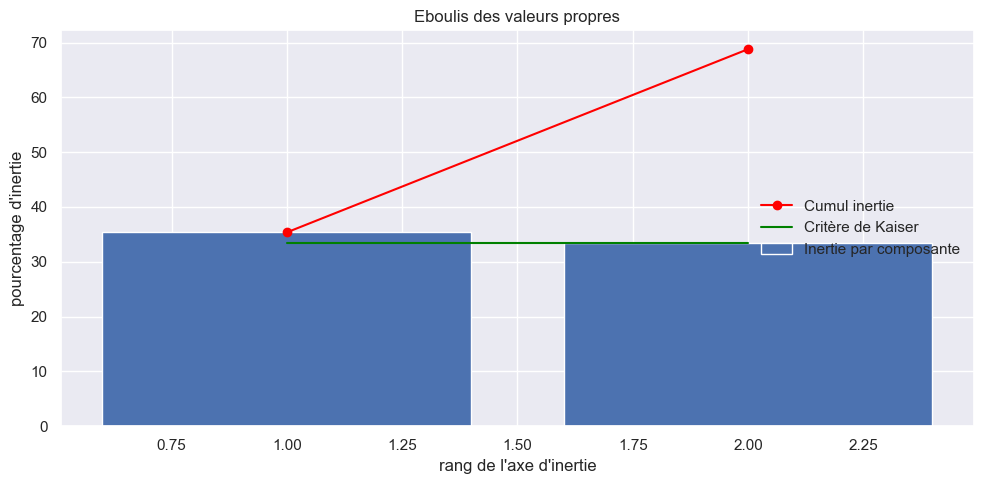

* Cercle(s) des corrélations et projections des individus dans les plans factoriels


In [26]:
# Fer et vitamine C
# Retour à l'affichage des graphiques dans le notebook
%matplotlib inline

# Choix du nombre de composantes à calculer
n_comp = 2

pca_features = ['vitamin-c_100g', 'iron_100g', 'nutrition-score-fr_100g']
data_pca = data[pca_features].copy()
X = data_pca.values
names = np.array(data_pca.index) # pour les labels de p_labels
pca_labels = np.array([s.replace("_100g", "") for s in pca_features]) # pour les labels de c_labels

print(fct.Fore.LIGHTGREEN_EX + "Analyse en Composantes principales (ACP)")
print("  -", data_pca.shape[1], 'variables')
print("  -", data_pca.shape[0], 'individus (produits)\n' + fct.Style.RESET_ALL)

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

np.set_printoptions(precision=3)
print(" - n_components_ : ", pca.n_components_)
print(" - explained_variance_ :", pca.explained_variance_)
print(" - explained_variance_ratio_ :", pca.explained_variance_ratio_)
print(" - singular_values_ :", pca.singular_values_)
print(" - components_ :", np.shape(pca.components_))
print('\n')

# Eboulis des valeurs propres
print(fct.Fore.LIGHTBLUE_EX + "* Eboulis des valeurs propres" + fct.Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(fct.Fore.LIGHTBLUE_EX + "* Cercle(s) des corrélations et projections des individus dans les plans factoriels" + fct.Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X_scaled)

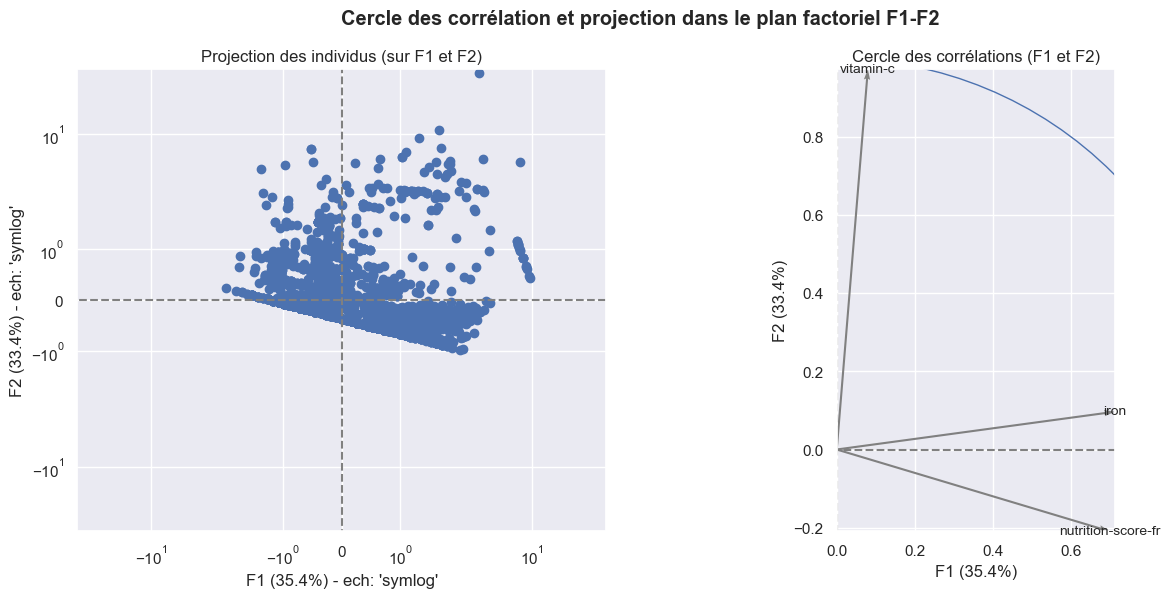

In [27]:
# Pour afficher les graphiques dans des fenêtres séparées
#%matplotlib qt

# Liste des plans pour l'affichage graphique
plans = [[i,i+1] for i in range(1, n_comp, 2)]
if n_comp % 2 != 0:
    plans.append([1, n_comp])

# Définition des échelles de tracé (projection des individus) et tracé des graphiques
scale = 'symlog', 'symlog'
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale, p_labels = None,
                           c_labels=pca_labels, c_label_rotation=0, c_lims=None, filter=0.3)
    plt.show()

Analyse en Composantes principales (ACP)
  - 10 variables
  - 4041 individus (produits)

 - n_components_ :  4
 - explained_variance_ : [3.009 1.35  1.032 0.995]
 - explained_variance_ratio_ : [0.301 0.135 0.103 0.099]
 - singular_values_ : [110.256  73.838  64.571  63.394]
 - components_ : (4, 10)


* Eboulis des valeurs propres


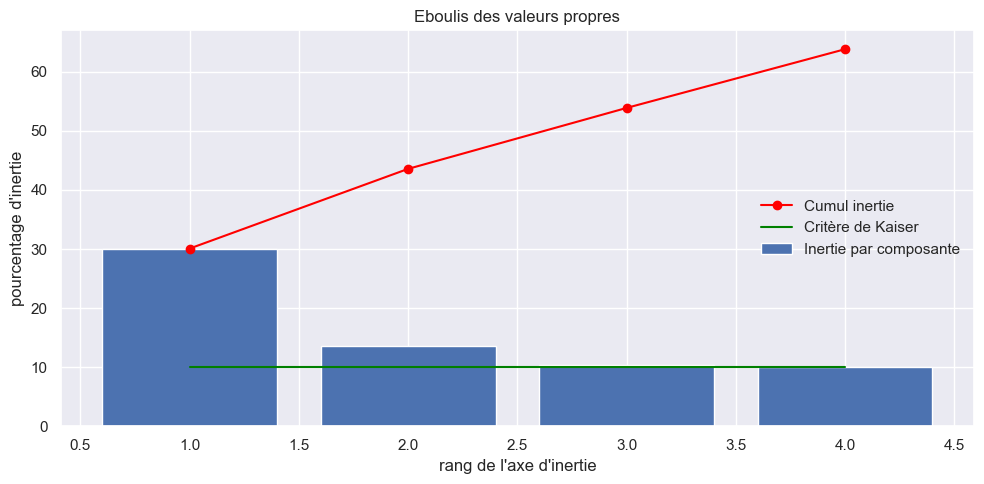

* Cercle(s) des corrélations et projections des individus dans les plans factoriels


In [28]:
# Magnésium et vitamines B
# Retour à l'affichage des graphiques dans le notebook
%matplotlib inline

# Choix du nombre de composantes à calculer
n_comp = 4

# Sélection des caractéristiques à prendre en compte dans l'ACP et préparation des données
pca_features = ['vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'pantothenic-acid_100g',
                'vitamin-b6_100g', 'biotin_100g', 'vitamin-b9_100g','vitamin-b12_100g', 'magnesium_100g', 'nutrition-score-fr_100g']
data_pca = data[pca_features].copy()
X = data_pca.values
names = np.array(data_pca.index) # pour les labels de p_labels
pca_labels = np.array([s.replace("_100g", "") for s in pca_features]) # pour les labels de c_labels

print(fct.Fore.LIGHTGREEN_EX + "Analyse en Composantes principales (ACP)")
print("  -", data_pca.shape[1], 'variables')
print("  -", data_pca.shape[0], 'individus (produits)\n' + fct.Style.RESET_ALL)

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

np.set_printoptions(precision=3)
print(" - n_components_ : ", pca.n_components_)
print(" - explained_variance_ :", pca.explained_variance_)
print(" - explained_variance_ratio_ :", pca.explained_variance_ratio_)
print(" - singular_values_ :", pca.singular_values_)
print(" - components_ :", np.shape(pca.components_))
print('\n')

# Eboulis des valeurs propres
print(fct.Fore.LIGHTBLUE_EX + "* Eboulis des valeurs propres" + fct.Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(fct.Fore.LIGHTBLUE_EX + "* Cercle(s) des corrélations et projections des individus dans les plans factoriels" + fct.Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X_scaled)

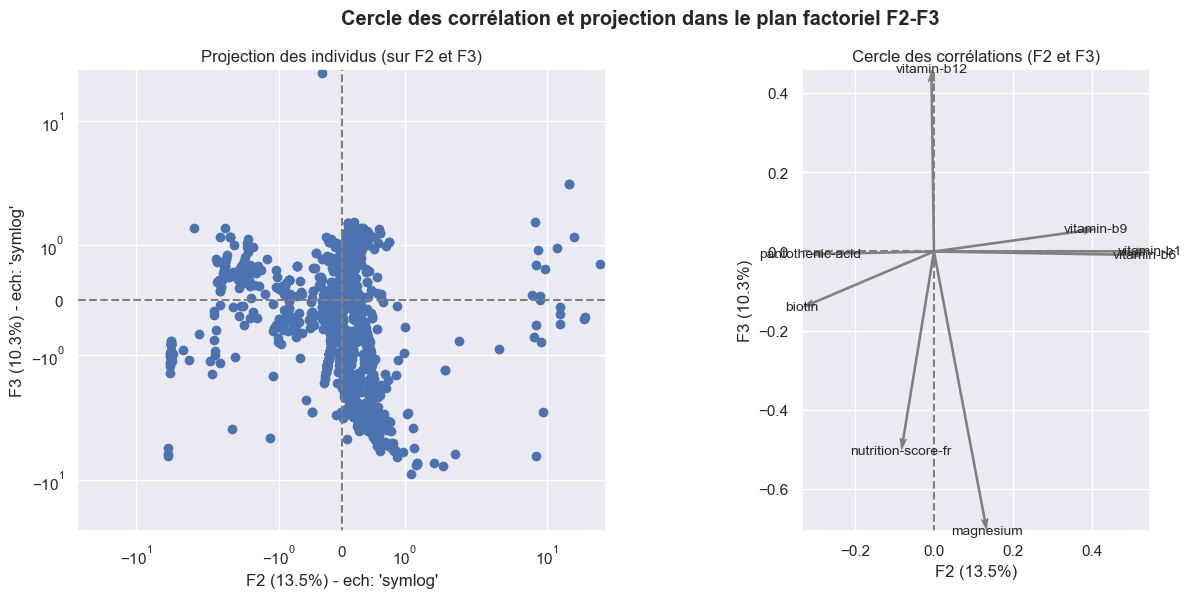

In [29]:
# Pour afficher les graphiques dans des fenêtres séparées
#%matplotlib qt

# Définition des échelles de tracé (projection des individus) et tracé des graphiques
plans=[[2,3]]
scale = 'symlog', 'symlog'
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale, p_labels = None,
                           c_labels=pca_labels, c_label_rotation=0, c_lims=None, filter=0.3)
    plt.show()

Analyse en Composantes principales (ACP)
  - 3 variables
  - 4041 individus (produits)

 - n_components_ :  2
 - explained_variance_ : [1.242 1.017]
 - explained_variance_ratio_ : [0.414 0.339]
 - singular_values_ : [70.822 64.089]
 - components_ : (2, 3)


* Eboulis des valeurs propres


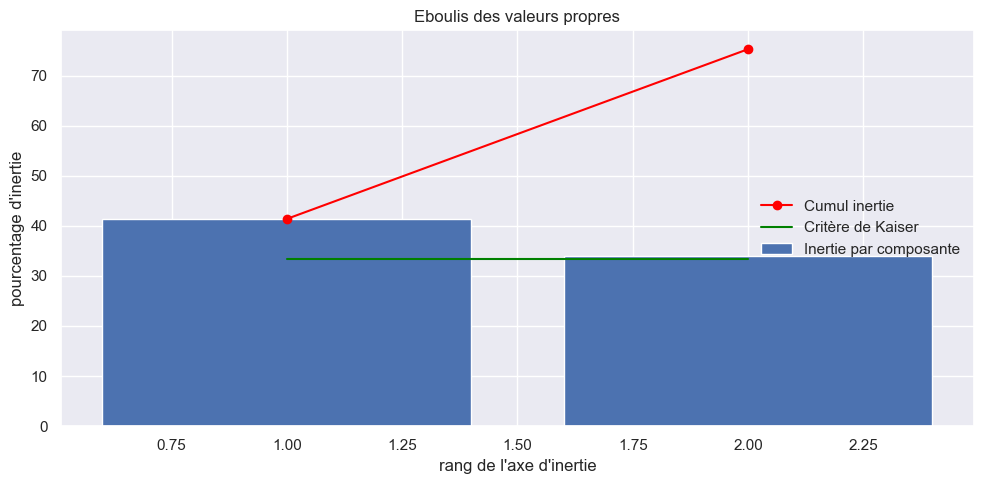

* Cercle(s) des corrélations et projections des individus dans les plans factoriels


In [30]:
# Calcium et vitamine D
# Retour à l'affichage des graphiques dans le notebook
%matplotlib inline

# Choix du nombre de composantes à calculer
n_comp = 2

# Sélection des caractéristiques à prendre en compte dans l'ACP et préparation des données
pca_features = ['vitamin-d_100g', 'calcium_100g', 'nutrition-score-fr_100g']
data_pca = data[pca_features].copy()
X = data_pca.values
names = np.array(data_pca.index) # pour les labels de p_labels
pca_labels = np.array([s.replace("_100g", "") for s in pca_features]) # pour les labels de c_labels

print(fct.Fore.LIGHTGREEN_EX + "Analyse en Composantes principales (ACP)")
print("  -", data_pca.shape[1], 'variables')
print("  -", data_pca.shape[0], 'individus (produits)\n' + fct.Style.RESET_ALL)

# Centrage et réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

np.set_printoptions(precision=3)
print(" - n_components_ : ", pca.n_components_)
print(" - explained_variance_ :", pca.explained_variance_)
print(" - explained_variance_ratio_ :", pca.explained_variance_ratio_)
print(" - singular_values_ :", pca.singular_values_)
print(" - components_ :", np.shape(pca.components_))
print('\n')

# Eboulis des valeurs propres
print(fct.Fore.LIGHTBLUE_EX + "* Eboulis des valeurs propres" + fct.Style.RESET_ALL)
fct.display_scree_plot(pca)

# Cercle des corrélations et projection des individus
print(fct.Fore.LIGHTBLUE_EX + "* Cercle(s) des corrélations et projections des individus dans les plans factoriels" + fct.Style.RESET_ALL)
pcs = pca.components_
X_projected = pca.transform(X_scaled)

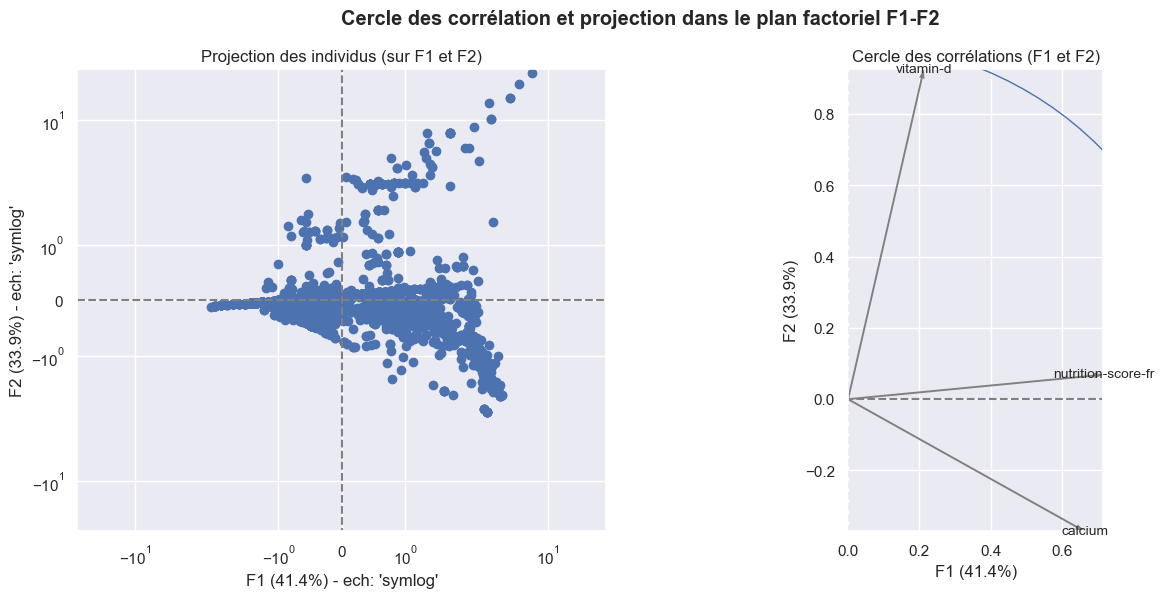

In [31]:
# Pour afficher les graphiques dans des fenêtres séparées
#%matplotlib qt

# Définition des échelles de tracé (projection des individus) et tracé des graphiques
plans=[[1,2]]
scale = 'symlog', 'symlog'
for plan in plans:
    fct.projetNcircle_plot(pcs, X_projected, n_comp, pca, plan, scale=scale, p_labels = None,
                           c_labels=pca_labels, c_label_rotation=0, c_lims=None, filter=0.3)
    plt.show()

<a id="anova"></a>
### ANOVA (ANalysis Of VAriance) et tests statistiques associés
Dans ce chapitre, nous examinons de plus près la corrélation entre certaines paires de caractéristiques catégorielle et numérique.

1) Nous examinons tout d'abord la **paire nutri-score et nutri-grade**
Nous avons déjà mis en évidence un rapport de corrélation élevé avec les analyses bivariées. Nous le vérifions à nouveau et modélisons la variable numérique en fonction des valeurs moyennes de chaque catégorie. Le résultat donne un coefficient de corrélation très élevé. Le rapport de corrélation est également très élevé quoique plus faible que le coefficient de corrélation compte tenu de la dispersion des valeurs du nutri-score autour de sa moyenne pour chaque catégorie.
&nbsp;
2) Dans la perspective de l'application envisagée, nous examinons deux autres paires :
    - Le **taux de graisses saturées en fonction de la catégorie des produits** montre un bon niveau de corrélation entre la variable numérique et ses valeurs moyennes. En conclusion de cette analyse, l'utilisateur qui souhaiterait minimiser la présence de graisses saturées dans les produits évitera donc les catégories suivantes, par ordre décroissant d'importance : 'Fat and sauces', 'Sugary snacks', 'Milky and dairy products', 'Salty snacks' et 'Composite food".
&nbsp;
    - Le **taux de sucre en fonction de la catégorie des produits** montre également un bon niveau de corrélation entre la variable numérique et ses valeurs moyennes, à l'exception des catégories 'fruits and vegetables' et 'cereals and potatoes' pour lesquelles nous ne pouvons montrer d'écart significatif entre leurs moyennes. En conclusion de cette analyse, l'utilisateur qui souhaiterait minimiser la présence de sucre dans les produits évitera donc les catégories suivantes, par ordre décroissant d'importance : 'Sugary snacks', 'Cereals and potatoes', 'Fruits and vegetables', et portera une attention particulière aux catégories de 'Beverages' et 'Milk and dairy'.

*[retour sommaire](#sommaire)*

* ANOVA pour le nutri-score selon le nutri-grade
Rapport de corrélation pour les k= 5 catégories du graphique et n= 4041 données : η²=0.88
 -> Test de normalité de Shapiro positif pour toutes les catégories
 -> Test d'homoscédasticité de Bartlett négatif : p-value=9.05e-282
    Ecarts types: [4.487 2.943 2.67  0.894 2.177]
 -> Test de Welch (non égalité des moyennes) positif pour toutes les catégories
Résultat positif du test de Fisher : F=641.83 > 2.37  , et p-value=2.51e-136 < 0.05
 Rappel des hypothèses relatives au test :
  - H0 : les moyennes par catégories sont égales entre elles (les variables sont indépendantes)
  - H1 : la moyenne d'au moins une catégorie diffère des autres (les variables sont corrélées)

Moyenne catégorielle : 'nutrition-score-fr_100g' = -4.48  + 5.55 * 'nutrition_grade_fr', avec : 'a'= 0 , …, 'e'= 4
 -->Coefficient de corrélation r² =0.99


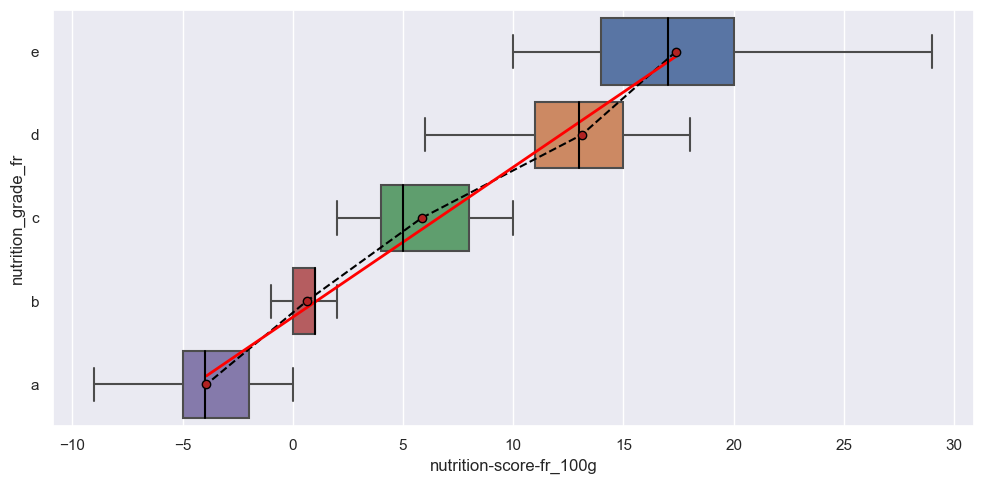

In [32]:
# ANOVA pour la paire [catégorielle, numérique] avec tri par valeurs moyennes
print(fct.Fore.LIGHTGREEN_EX + "* ANOVA pour le nutri-score selon le nutri-grade" + fct.Style.RESET_ALL)
pair = ['nutrition_grade_fr', 'nutrition-score-fr_100g']
fct.anova(data, pair, nb_cat=5)

* ANOVA pour les boissons
Rapport de corrélation pour les k= 5 catégories du graphique et n= 988 données : η²=0.92
 -> Test de normalité de Shapiro positif pour toutes les catégories
 -> Test d'homoscédasticité de Bartlett négatif : p-value=7.69e-82
    Ecarts types: [2.97  1.528 0.999 1.331 1.537]
 -> Test de Welch (non égalité des moyennes) positif pour toutes les catégories
Résultat positif du test de Fisher : F=296.68 > 2.38  , et p-value=4.75e-62 < 0.05
 Rappel des hypothèses relatives au test :
  - H0 : les moyennes par catégories sont égales entre elles (les variables sont indépendantes)
  - H1 : la moyenne d'au moins une catégorie diffère des autres (les variables sont corrélées)

Moyenne catégorielle : 'nutrition-score-fr_100g' = -4.28  + 4.44 * 'nutrition_grade_fr', avec : 'a'= 0 , …, 'e'= 4
 -->Coefficient de corrélation r² =0.96


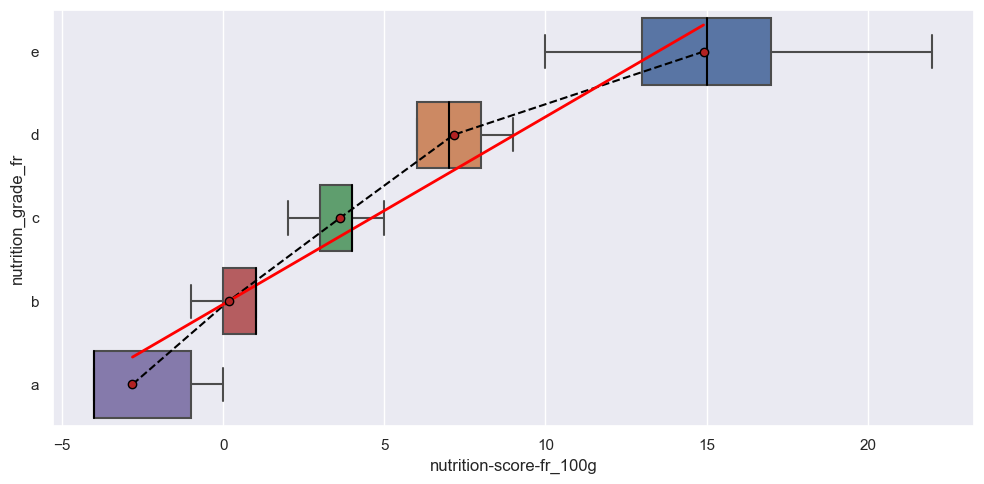

* ANOVA pour la nourriture solide
Rapport de corrélation pour les k= 5 catégories du graphique et n= 3053 données : η²=0.93
 -> Test de normalité de Shapiro positif pour toutes les catégories
 -> Test d'homoscédasticité de Bartlett négatif : p-value=7.29e-166
    Ecarts types: [3.071 2.14  2.442 0.775 2.218]
 -> Test de Welch (non égalité des moyennes) positif pour toutes les catégories
Résultat positif du test de Fisher : F=401.21 > 2.37  , et p-value=1.72e-86 < 0.05
 Rappel des hypothèses relatives au test :
  - H0 : les moyennes par catégories sont égales entre elles (les variables sont indépendantes)
  - H1 : la moyenne d'au moins une catégorie diffère des autres (les variables sont corrélées)

Moyenne catégorielle : 'nutrition-score-fr_100g' = -5.22  + 6.56 * 'nutrition_grade_fr', avec : 'a'= 0 , …, 'e'= 4
 -->Coefficient de corrélation r² =0.99


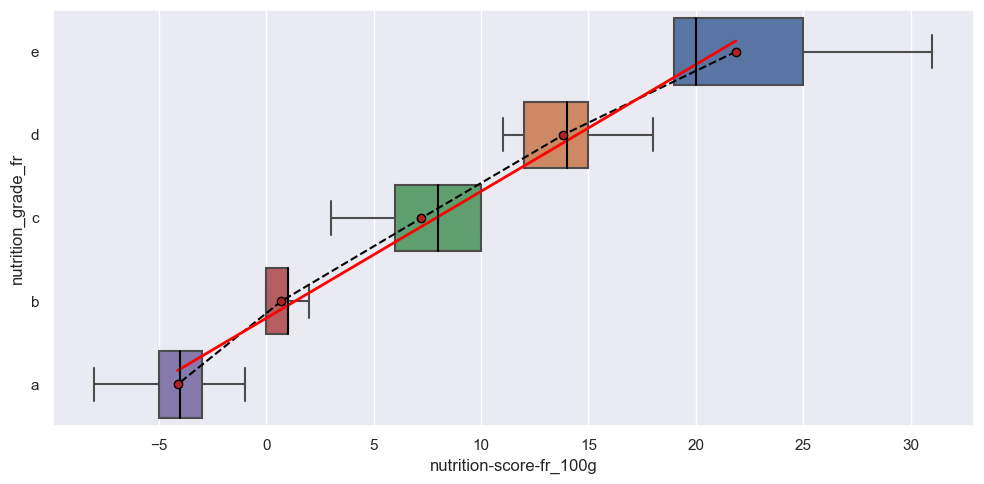

In [33]:
# Préparations des dataframes pour les calculs et tracés
print(fct.Fore.LIGHTGREEN_EX + "* ANOVA pour les boissons" + fct.Style.RESET_ALL)
dfb = pd.DataFrame([])
dfb['nutrition-score-fr_100g'] = data.loc[data['pnns_groups_1']=='Beverages', 'nutrition-score-fr_100g']
dfb['nutrition_grade_fr'] = data.loc[data['pnns_groups_1']=='Beverages', 'nutrition_grade_fr']
fct.anova(dfb, pair, nb_cat=5)

print(fct.Fore.LIGHTGREEN_EX + "* ANOVA pour la nourriture solide" + fct.Style.RESET_ALL)
dfs = pd.DataFrame([])
dfs['nutrition-score-fr_100g'] = data.loc[data['pnns_groups_1']!='Beverages', 'nutrition-score-fr_100g']
dfs['nutrition_grade_fr'] = data.loc[data['pnns_groups_1']!='Beverages', 'nutrition_grade_fr']
fct.anova(dfs, pair, nb_cat=5)

* ANOVA pour le score nutritionnel selon la catégorie du produit
Rapport de corrélation pour les k= 5 catégories du graphique et n= 2922 données : η²=0.20
 -> Test de normalité de Shapiro positif pour toutes les catégories
 -> Test d'homoscédasticité de Bartlett négatif : p-value=6.68e-12
    Ecarts types: [6.717 4.847 8.131 6.404 6.899]
 -> Test de Welch négatif entre les catégories ' Sugary snacks ' et ' Fat and sauces ' : W=0.80, p-value=0.422, dof=737.69
 -> Test de Welch négatif entre les catégories ' Salty snacks ' et ' Beverages ' : W=1.23, p-value=0.229, dof=32.26
 -> Test de Welch négatif entre les catégories ' Salty snacks ' et ' Milk and dairy products ' : W=1.77, p-value=0.086, dof=32.24
Résultat positif du test de Fisher : F=919.80 > 2.37  , et p-value=9.23e-188 < 0.05
 Rappel des hypothèses relatives au test :
  - H0 : les moyennes par catégories sont égales entre elles (les variables sont indépendantes)
  - H1 : la moyenne d'au moins une catégorie diffère des autres (les

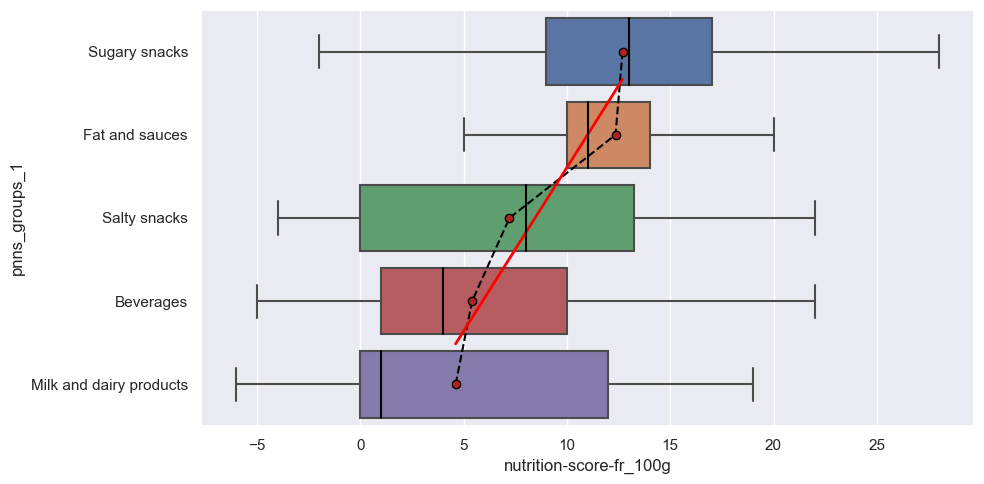

In [34]:
# ANOVA pour la paire ['pnns_groups_1', 'nutrition-score-fr_100g']
print(fct.Fore.LIGHTGREEN_EX + "* ANOVA pour le score nutritionnel selon la catégorie du produit" + fct.Style.RESET_ALL)
pair = ['pnns_groups_1', 'nutrition-score-fr_100g']
fct.anova(data, pair, nb_cat=5)

* ANOVA pour le taux de graisses saturées selon la catégorie du produit
Rapport de corrélation pour les k= 5 catégories du graphique et n= 2011 données : η²=0.18
 -> Test de normalité de Shapiro positif pour toutes les catégories
 -> Test d'homoscédasticité de Bartlett négatif : p-value=6.50e-86
    Ecarts types: [14.819  7.736  7.992  3.524  2.905]
 -> Test de Welch (non égalité des moyennes) positif pour toutes les catégories
Résultat positif du test de Fisher : F=871.73 > 2.38  , et p-value=1.41e-173 < 0.05
 Rappel des hypothèses relatives au test :
  - H0 : les moyennes par catégories sont égales entre elles (les variables sont indépendantes)
  - H1 : la moyenne d'au moins une catégorie diffère des autres (les variables sont corrélées)

Moyenne catégorielle : 'saturated-fat_100g' = -0.99  + 4.34 * 'pnns_groups_1', avec : 'Composite foods'= 0 , …, 'Fat and sauces'= 4
 -->Coefficient de corrélation r² =0.80


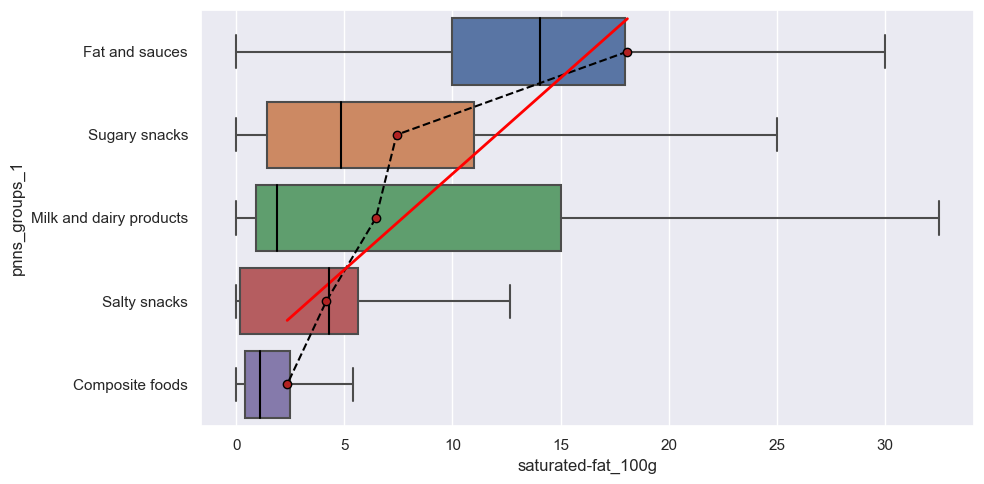

In [35]:
# ANOVA pour la paire ['pnns_groups_1', 'saturated-fat_100g']
print(fct.Fore.LIGHTGREEN_EX + "* ANOVA pour le taux de graisses saturées selon la catégorie du produit" + fct.Style.RESET_ALL)
pair = ['pnns_groups_1', 'saturated-fat_100g']
fct.anova(data, pair, nb_cat=5)

* ANOVA pour le taux de sucre selon la catégorie du produit
Rapport de corrélation pour les k= 7 catégories du graphique et n= 3627 données : η²=0.35
 -> Test de normalité de Shapiro positif pour toutes les catégories
 -> Test d'homoscédasticité de Bartlett négatif : p-value=0.00e+00
    Ecarts types: [21.955 12.245 16.555  9.438  5.299  2.778  3.952]
 -> Test de Welch négatif entre les catégories ' Cereals and potatoes ' et ' Fruits and vegetables ' : W=0.31, p-value=0.758, dof=430.96
Résultat positif du test de Fisher : F=1467.88 > 2.10  , et p-value=1.22e-292 < 0.05
 Rappel des hypothèses relatives au test :
  - H0 : les moyennes par catégories sont égales entre elles (les variables sont indépendantes)
  - H1 : la moyenne d'au moins une catégorie diffère des autres (les variables sont corrélées)

Moyenne catégorielle : 'sugars_100g' = -4.44  + 5.45 * 'pnns_groups_1', avec : 'Composite foods'= 0 , …, 'Sugary snacks'= 6
 -->Coefficient de corrélation r² =0.80


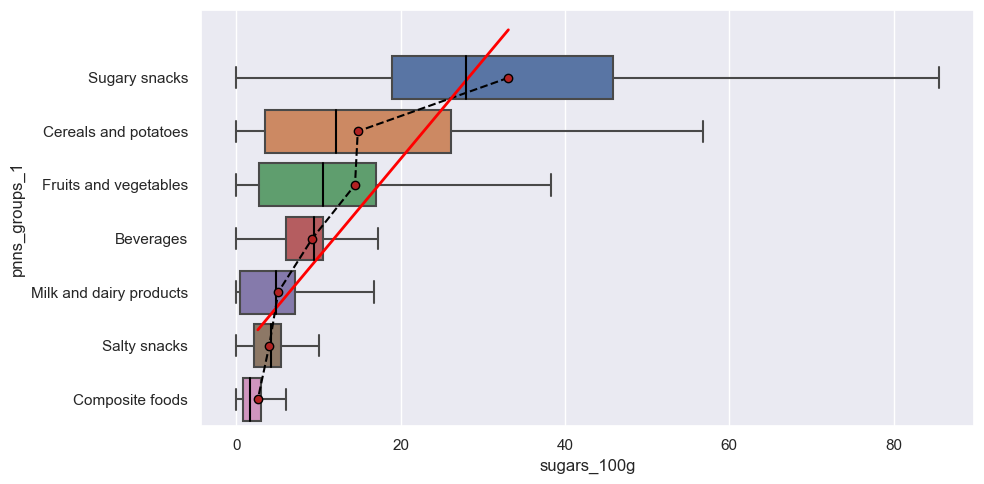

In [36]:
# ANOVA pour la paire ['pnns_groups_1', 'sugars_100g']
print(fct.Fore.LIGHTGREEN_EX + "* ANOVA pour le taux de sucre selon la catégorie du produit" + fct.Style.RESET_ALL)
pair = ['pnns_groups_1', 'sugars_100g']
fct.anova(data, pair, nb_cat=7)

<a id="appli"></a>
### L'application envisagée

Nous illustrons ici l'utilisation de l'application par la recherche de bonnes associations entre vitamines et minéraux telles que (*source: Top Santé)* :
  - **Fer et vitamine C** : l'absorption du fer est meilleure lorsqu'il est accompagné de vitamine C ; à noter : le thé diminue l'absorption du fer, on évite donc d'en boire au cours du repas.
&nbsp;
  - **Selenium et vitamine E** : oligoélément anti-âge, aide à se défendre contre les radicaux libres. Il facilite aussi la rétention de la vitamine E dans le plasma - la partie liquide du sang - et celle-ci diminue les besoins de l'organisme en sélénium en en prévenant les pertes.
&nbsp;
  - **Magnésium et vitamines B** : les vitamines du groupe B sont plus efficaces lorsqu'elles sont associées au magnésium. Un complexe associant les deux (sans fer ni cuivre, pro-oxydants) corrigera les carences en un mois. Important, car elle sert à fabriquer de nombreux neurotransmetteurs comme le GABA, anti-anxiété, ou bien la taurine, sédative. Et ce circuit est le même pour la vitamine B2, nécessaire à l'activation de la vitamine B3 (PP). Cela signifie qu'un manque de vitamine B2 peut entraîner un déficit en vitamine B3.
&nbsp;
  - **Calcium et vitamine D** : le calcium ne peut pas se fixer sur les os si la vitamine D n'est pas présente pour lui permettre d'être absorbé par l'intestin puis par les reins.
&nbsp;
  - **Magnésium et calcium** : essentiels à la bonne santé des os et des dents, ainsi qu'au bon fonctionnement musculaire et au métabolisme. Le magnésium agit comme un régulateur du calcium. Par exemple, la contraction d'un muscle est déclenchée par une entrée de calcium dans la cellule, or c'est le magnésium qui contrôle la quantité de calcium y pénétrant. Donc, si on se sent crispé, c'est le plus souvent qu'on manque de magnésium. Il est recommandé globalement d'associer le calcium et le magnésium dans un rapport de 2 à 1.

&nbsp;
À partir de ces associations, nous listons les produits par ordre décroissant de score nutritionnel (de A à E), filtrons en fonction des éléments à exclure (ex: huile de palme) et minimisons l'élément choisi (ex: graisses saturées). Cela donne une liste de produits préférentiels classés associés à des informations complémentaires pour apporter des renseignements complémentaires à l'utilisateur.

*[retour sommaire](#sommaire)*

In [37]:
# Liste des associations
associations = [['vitamin-c_100g', 'iron_100g'], ['vitamin-e_100g', 'selenium_100g'], ['vitamin-d_100g', 'calcium_100g'],
                ['calcium_100g', 'magnesium_100g'], ['vitamin-b1_100g', 'magnesium_100g']]
vitB_Mg = ['vitamin-b1_100g', 'vitamin-b2_100g', 'vitamin-pp_100g', 'pantothenic-acid_100g',
            'vitamin-b6_100g', 'biotin_100g', 'vitamin-b9_100g','vitamin-b12_100g', 'magnesium_100g']
to_minimise = ['salt_100g', 'saturated-fat_100g', 'trans-fat_100g', 'sugars_100g']
to_display = ['product_name', 'url', 'brands', 'stores', 'nutrition_grade_fr', 'pnns_groups_1', 'additives_n',
              'additives_tags', 'allergens', 'palm', 'salt_100g', 'saturated-fat_100g', 'trans-fat_100g', 'sugars_100g']

for association in associations:
    print(fct.Fore.LIGHTGREEN_EX + "* Association", association, ":" + fct.Style.RESET_ALL)
    display(fct.appli(data, association, to_minimise=['saturated-fat_100g'], to_exclude=[['palm'],[True]],
                      sort_by=[['nutrition_grade_fr'],[True]], to_display=to_display))

print(fct.Fore.LIGHTGREEN_EX + "* Association du magnésium avec la famille des vitamines B :" + fct.Style.RESET_ALL)
display(fct.appli(data, vitB_Mg, keep='magnesium_100g', to_minimise=['saturated-fat_100g'], to_exclude=[['palm'],['True']],
                  sort_by=[['nutrition_grade_fr'],[True]], to_display=to_display))

* Association ['vitamin-c_100g', 'iron_100g'] :


,product_name,url,brands,stores,nutrition_grade_fr,pnns_groups_1,additives_n,additives_tags,allergens,palm,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,vitamin-c_100g,iron_100g
88,Baies de Goji biologiques,http://world-fr.openfoodfacts.org/produit/0766773121303/baies-de-goji-biologiques-comptoirs-et-compagnies,Comptoirs et Compagnies,***unknown***,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.018,0.008
106,Prenium CTC leaf black tea,http://world-fr.openfoodfacts.org/produit/103106/prenium-ctc-leaf-black-tea-madupatty,Madupatty,***unknown***,a,Beverages,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.100,0.060
3218,Baies de Goji Biologiques,http://world-fr.openfoodfacts.org/produit/3760123181297/baies-de-goji-biologiques-comptoirs-et-compagnies,Comptoirs et Compagnies,***unknown***,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.018,0.008
3219,Baies de Goji biologiques,http://world-fr.openfoodfacts.org/produit/3760123181426/baies-de-goji-biologiques-lyn,LYN,Auchan,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.018,0.008
3349,Falafel,http://world-fr.openfoodfacts.org/produit/5034444113106/falafel-al-fez,"Al' Fez, Alfez Ltd",Irma.dk,a,Composite foods,1.0,en:e500,NaN,False,2.921e+00,0.00,0.0,7.50,0.009,0.009
3492,Roasted Red Pepper,http://world-fr.openfoodfacts.org/produit/5201119003547/roasted-red-pepper-palirria,Palirria,***unknown***,a,Fruits and vegetables,0.0,NaN,NaN,False,1.020e+00,0.00,0.0,3.33,0.072,0.004
3807,Mûres noires BIO,http://world-fr.openfoodfacts.org/produit/7640149390155/mures-noires-bio-optimyc,Optimyc,***unknown***,a,Fruits and vegetables,0.0,NaN,NaN,***unknown***,1.194e-01,0.00,0.0,0.00,0.036,0.009
3182,Mûres Noires,http://world-fr.openfoodfacts.org/produit/3760048990479/mures-noires-ubertfs,Ubertfs,Naturalia,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.10,0.0,40.50,0.108,0.009
3163,Muesli superfruits sans sucres ajoutés,http://world-fr.openfoodfacts.org/produit/3760020503819/muesli-superfruits-sans-sucres-ajoutes-jardin-bio,Jardin Bio,Auchan,a,Cereals and potatoes,0.0,NaN,"blé, seigle, avoine, orge",False,1.501e-01,0.70,0.0,11.90,0.016,0.003
3633,Nestum mel,http://world-fr.openfoodfacts.org/produit/5601001228100/nestum-mel-nestle,"Nestlé,Nestum","Intermarché,Auchan",b,Cereals and potatoes,2.0,"en:e170,en:e300","blé, blé",False,1.500e-02,0.20,0.0,29.00,0.051,0.015


* Association ['vitamin-e_100g', 'selenium_100g'] :


,product_name,url,brands,stores,nutrition_grade_fr,pnns_groups_1,additives_n,additives_tags,allergens,palm,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,vitamin-e_100g,selenium_100g
917,Sélégerme,http://world-fr.openfoodfacts.org/produit/3175681197350/selegerme-gerble,Gerblé,Carrefour,a,Cereals and potatoes,1.0,en:e306,"blé, orge",False,8.000e-02,1.40,0.0,6.30,0.013,1.051e-03
1876,Germalyne Tradition,http://world-fr.openfoodfacts.org/produit/3264950111125/germalyne-tradition-abbaye-de-sept-fons,Abbaye de Sept-Fons,Bio14,a,Cereals and potatoes,0.0,NaN,NaN,False,5.000e-02,1.80,0.0,13.00,0.012,1.650e-05
1486,Sélégerme,http://world-fr.openfoodfacts.org/produit/3251490435552/selegerme-gerble,"Gerblé,Céréal",***unknown***,a,Cereals and potatoes,1.0,en:e306,NaN,False,4.620e-02,1.82,0.0,7.27,0.015,1.051e-03
2492,Jour après Jour Jeunesse Écrémé,http://world-fr.openfoodfacts.org/produit/3428273950209/jour-apres-jour-jeunesse-ecreme-lactel,"Lactel,Jour après Jour",Banque alimentaire,b,Milk and dairy products,3.0,"en:e331,en:e516,en:e306",Lait,False,1.270e-01,0.10,0.0,5.10,0.002,8.300e-06
2120,Maxi format Eveil croissance nature,http://world-fr.openfoodfacts.org/produit/3288110800018/maxi-format-eveil-croissance-nature-lactel,"Lactel,Eveil",Auchan,b,Milk and dairy products,5.0,"en:e333,en:e341,en:e332,en:e331,en:e574","Lait, lait, lait, lait, lait",False,8.128e-02,1.40,0.0,5.50,0.001,3.000e-06
2121,Eveil croissance nature,http://world-fr.openfoodfacts.org/produit/3288110828401/eveil-croissance-nature-lactel,"Lactel,Eveil",Auchan,b,Milk and dairy products,5.0,"en:e333,en:e341,en:e332,en:e331,en:e574","Lait, lait, lait, lait, lait",False,8.128e-02,1.40,0.0,5.50,0.001,3.000e-06
909,Barres chocolat noir intense,http://world-fr.openfoodfacts.org/produit/3175681125896/barres-chocolat-noir-intense-gerlinea,Gerlinéa,***unknown***,d,Sugary snacks,9.0,"en:e322,en:e1400,en:e420,en:e470,en:e341,en:e504,en:e101,en:e300,en:e306","lait, soja, lait, gluten, blé, soja, lactose",False,7.130e-01,5.97,0.0,25.00,0.008,3.550e-05
3378,"Super smoothie Antioxydant kiwi, citron vert, herbe de blé et graine de lin",http://world-fr.openfoodfacts.org/produit/5038862232531/super-smoothie-antioxydant-kiwi-citron-vert-herbe-de-ble-et-graine-de-lin-innocent,Innocent,Monoprix,e,Beverages,1.0,en:e306,NaN,False,0.000e+00,0.20,0.0,12.00,0.002,1.500e-05
3380,Innocent Super Smoothie Antioxidant,http://world-fr.openfoodfacts.org/produit/5038862238977/innocent-super-smoothie-antioxidant,Innocent,W H Smith,e,Beverages,0.0,NaN,NaN,False,0.000e+00,0.20,0.0,12.00,0.002,1.500e-05
1302,"Milk-Shake substitut de repas, saveur vanille (x 3)",http://world-fr.openfoodfacts.org/produit/3245412642548/milk-shake-substitut-de-repas-saveur-vanille-x-3-agir-carrefour-nutrition,"Agir Carrefour nutrition,Groupe Carrefour",Carrefour,e,Beverages,12.0,"en:e340,en:e322,en:e407,en:e511,en:e331,en:e101,en:e306,en:e300,en:e160a,en:e950,en:e574,en:e516",NaN,False,1.800e-01,0.50,0.0,6.00,0.002,1.800e-05


* Association ['vitamin-d_100g', 'calcium_100g'] :


,product_name,url,brands,stores,nutrition_grade_fr,pnns_groups_1,additives_n,additives_tags,allergens,palm,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,vitamin-d_100g,calcium_100g
172,Fromage blanc 0% matière grasse,http://world-fr.openfoodfacts.org/produit/20692384/fromage-blanc-0-matiere-grasse-envia,Envia,Lidll,a,Milk and dairy products,0.0,NaN,Lait,False,0.100,0.0,0.0,4.7,5.000e-06,0.200
280,Ferme & Fondant Nature (0 % MG) 8 Pots,http://world-fr.openfoodfacts.org/produit/3023291127000/ferme-fondant-nature-0-mg-8-pots-nestle,"Nestlé,Sveltesse",Super U,a,Milk and dairy products,1.0,en:e441,Lait,False,0.160,0.0,0.0,4.3,1.000e-06,0.142
1305,Yaourt Aromatisé 0%,http://world-fr.openfoodfacts.org/produit/3245413439512/yaourt-aromatise-0-carrefour,Carrefour,Carrefour,a,Milk and dairy products,2.0,"en:e950,en:e960",NaN,False,0.127,0.0,0.0,4.5,1.250e-06,0.120
2752,Yaourt & Fruits 0%,http://world-fr.openfoodfacts.org/produit/3560070802210/yaourt-fruits-0-carrefour,Carrefour,Carrefour,a,Milk and dairy products,10.0,"en:e1200,en:e14xx,en:e440,en:e120,en:e160,en:e163,en:e150a,en:e955,en:e415,en:e950","Lait, lait, lait, lactiques, lait",False,0.130,0.0,0.0,4.1,7.800e-07,0.120
2782,"Déli'Light yaourt aux fruits (cerise, mûre, fraise, ananas, abricot, citron)",http://world-fr.openfoodfacts.org/produit/3564700007228/deli-light-yaourt-aux-fruits-cerise-mure-fraise-ananas-abricot-citron-delisse,"Délisse,Marque Repère",Leclerc,a,Milk and dairy products,11.0,"en:e1200,en:e14xx,en:e440,en:e415,en:e412,en:e163,en:e160,en:e210,en:e160c,en:e950,en:e955","Lait, lait, lait, lait, lait",False,0.150,0.0,0.0,5.3,1.200e-06,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,Nesquik moins de sucres,http://world-fr.openfoodfacts.org/produit/7613035530799/nesquik-moins-de-sucres,Nesquik,Bordeaux,e,Beverages,4.0,"en:e1400,en:e322,en:e450,en:e300",NaN,False,0.150,1.0,0.0,7.0,7.100e-07,0.116
2633,Viva Chocolat,http://world-fr.openfoodfacts.org/produit/3533630086511/viva-chocolat-candia,"Candia,Candia Viva","Cora,Auchan",e,Beverages,3.0,"en:e407,en:e101,en:e306",Lait,False,0.100,1.1,0.0,8.7,7.500e-07,0.120
3724,Nesquik goût Extra Choco,http://world-fr.openfoodfacts.org/produit/7613033214004/nesquik-gout-extra-choco-nestle,"Nestlé,Nesquik","Carrefour,Cora",e,Beverages,2.0,"en:e322,en:e450",soja,False,0.140,1.1,0.0,8.8,7.100e-07,0.120
259,Pom'potes brassés aux fruits mixés,http://world-fr.openfoodfacts.org/produit/3021760404157/pom-potes-brasse%CC%81s-aux-fruits-mixe%CC%81s-materne,Materne,casino,e,Beverages,1.0,en:e440,NaN,False,0.140,1.2,0.0,15.0,1.450e-06,0.145


* Association ['calcium_100g', 'magnesium_100g'] :


,product_name,url,brands,stores,nutrition_grade_fr,pnns_groups_1,additives_n,additives_tags,allergens,palm,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,calcium_100g,magnesium_100g
567,Eau Evian,http://world-fr.openfoodfacts.org/produit/3068320111919/eau-evian,Evian,***unknown***,a,Beverages,0.0,NaN,NaN,***unknown***,1.651e-03,0.00,0.0,0.00,0.080,0.026
569,Eau minérale naturelle,http://world-fr.openfoodfacts.org/produit/3068320114453/eau-minerale-naturelle-badoit,"Badoit,Danone",Dia,a,Beverages,0.0,NaN,NaN,False,4.572e-02,0.00,0.0,0.00,0.153,0.080
1410,Eau minérale naturelle renforcée au gaz de la source,http://world-fr.openfoodfacts.org/produit/3250391008728/eau-minerale-naturelle-renforcee-au-gaz-de-la-source-sainte-marguerite,Sainte Marguerite,Auchan,a,Beverages,0.0,NaN,NaN,False,7.671e-02,0.00,0.0,0.00,0.071,0.040
1684,Lisbeth,http://world-fr.openfoodfacts.org/produit/3256860710505/lisbeth,Lisbeth,Vosges Opération Libre,a,Beverages,0.0,NaN,NaN,False,1.930e-01,0.00,0.0,0.00,0.078,0.028
2521,Gros sel de Guérande,http://world-fr.openfoodfacts.org/produit/3445850070778/gros-sel-de-guerande-le-guerandais,Le Guérandais,Biocoop,a,Fish Meat Eggs,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.152,0.420
3016,eau de sources de montagnes,http://world-fr.openfoodfacts.org/produit/3596710387762/eau-de-sources-de-montagnes-auchan,auchan,***unknown***,a,Beverages,0.0,NaN,NaN,***unknown***,7.620e-03,0.00,0.0,0.00,0.058,0.024
3159,eau de source,http://world-fr.openfoodfacts.org/produit/3760000950220/eau-de-source-beaupre,Beaupré,***unknown***,a,Beverages,0.0,NaN,NaN,False,7.620e-03,0.00,0.0,0.00,0.058,0.024
3202,"Poudre de cacao cru, sans sucre, qualité premium",http://world-fr.openfoodfacts.org/produit/3760087361001/poudre-de-cacao-cru-sans-sucre-qualite-premium-ethnoscience,"Ethnoscience,Ecoidées",La Vie Claire,a,Sugary snacks,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.209,0.605
3658,Dattes de Tunisie,http://world-fr.openfoodfacts.org/produit/6191514300107/dattes-de-tunisie-nouri,Nouri,Dia,a,Fruits and vegetables,0.0,NaN,NaN,***unknown***,2.540e-03,0.00,0.0,0.00,0.071,0.063
3717,Eau minérale naturelle,http://world-fr.openfoodfacts.org/produit/7613032773670/eau-minerale-naturelle-vittel,Vittel,***unknown***,a,Beverages,0.0,NaN,NaN,False,1.321e-02,0.00,0.0,0.00,0.240,0.042


* Association ['vitamin-b1_100g', 'magnesium_100g'] :


,product_name,url,brands,stores,nutrition_grade_fr,pnns_groups_1,additives_n,additives_tags,allergens,palm,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,vitamin-b1_100g,magnesium_100g
705,Mogette de Vendée Sabarot,http://world-fr.openfoodfacts.org/produit/3111950227304/mogette-de-vendee-sabarot,Sabarot,Monoprix,a,Fruits and vegetables,0.0,NaN,NaN,False,1.250e-02,0.00,0.0,2.38,5.000e-04,0.180
706,Haricots cocos Sabarot,http://world-fr.openfoodfacts.org/produit/3111950231905/haricots-cocos-sabarot,Sabarot,Carrefour,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.180
707,Pois cassés de France Sabarot,http://world-fr.openfoodfacts.org/produit/3111950241201/pois-casses-de-france-sabarot,Sabarot,Carrefour,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.089
1281,"Noix de Grenoble, sèches",http://world-fr.openfoodfacts.org/produit/3241960500309/noix-de-grenoble-seches-valnoix,"Valnoix,Ville SA",Super U,a,Salty snacks,0.0,NaN,NaN,False,8.001e-03,0.00,0.0,3.20,2.800e-04,0.141
1942,Pois Chiches,http://world-fr.openfoodfacts.org/produit/3266191107639/pois-chiches-la-vie-claire,La Vie Claire,***unknown***,a,Cereals and potatoes,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.115
1943,Lentilles Corail,http://world-fr.openfoodfacts.org/produit/3266191107677/lentilles-corail-la-vie-claire,La Vie Claire,La Vie Claire,a,Cereals and potatoes,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.107
3658,Dattes de Tunisie,http://world-fr.openfoodfacts.org/produit/6191514300107/dattes-de-tunisie-nouri,Nouri,Dia,a,Fruits and vegetables,0.0,NaN,NaN,***unknown***,2.540e-03,0.00,0.0,0.00,3.962e-01,0.063
2970,Hydra Ananas Coco,http://world-fr.openfoodfacts.org/produit/3583788386674/hydra-ananas-coco-aptonia,Aptonia,Décathlon,a,Beverages,7.0,"en:e330,en:e345,en:e202,en:e242,en:e950,en:e955,en:e306",NaN,False,1.000e-02,0.10,0.0,0.10,8.400e-05,0.028
479,haricots rouges,http://world-fr.openfoodfacts.org/produit/3039825400310/haricots-rouges-vivien-paille,Vivien Paille,Auchan,a,Cereals and potatoes,0.0,NaN,NaN,False,3.048e-02,0.15,0.0,3.37,6.500e-04,0.138
287,Lentilles Vertes,http://world-fr.openfoodfacts.org/produit/3030824100348/lentilles-vertes-vivien-paille,Vivien Paille,***unknown***,a,Fruits and vegetables,0.0,NaN,NaN,False,5.994e-02,0.20,0.0,1.00,5.000e-04,0.100


* Association du magnésium avec la famille des vitamines B :


,product_name,url,brands,stores,nutrition_grade_fr,pnns_groups_1,additives_n,additives_tags,allergens,palm,salt_100g,saturated-fat_100g,trans-fat_100g,sugars_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,pantothenic-acid_100g,vitamin-b6_100g,biotin_100g,vitamin-b9_100g,vitamin-b12_100g,magnesium_100g
705,Mogette de Vendée Sabarot,http://world-fr.openfoodfacts.org/produit/3111950227304/mogette-de-vendee-sabarot,Sabarot,Monoprix,a,Fruits and vegetables,0.0,NaN,NaN,False,1.250e-02,0.00,0.0,2.38,5.000e-04,0.000e+00,0.000,0.000e+00,5.000e-04,0.000e+00,0.000e+00,0.000e+00,0.180
706,Haricots cocos Sabarot,http://world-fr.openfoodfacts.org/produit/3111950231905/haricots-cocos-sabarot,Sabarot,Carrefour,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.000e+00,0.000,0.000e+00,5.000e-04,0.000e+00,0.000e+00,0.000e+00,0.180
707,Pois cassés de France Sabarot,http://world-fr.openfoodfacts.org/produit/3111950241201/pois-casses-de-france-sabarot,Sabarot,Carrefour,a,Fruits and vegetables,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.000e+00,0.000,0.000e+00,5.000e-04,0.000e+00,0.000e+00,0.000e+00,0.089
1281,"Noix de Grenoble, sèches",http://world-fr.openfoodfacts.org/produit/3241960500309/noix-de-grenoble-seches-valnoix,"Valnoix,Ville SA",Super U,a,Salty snacks,0.0,NaN,NaN,False,8.001e-03,0.00,0.0,3.20,2.800e-04,0.000e+00,0.000,0.000e+00,4.000e-04,0.000e+00,0.000e+00,0.000e+00,0.141
1942,Pois Chiches,http://world-fr.openfoodfacts.org/produit/3266191107639/pois-chiches-la-vie-claire,La Vie Claire,***unknown***,a,Cereals and potatoes,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.000e+00,0.000,0.000e+00,5.000e-04,0.000e+00,0.000e+00,0.000e+00,0.115
1943,Lentilles Corail,http://world-fr.openfoodfacts.org/produit/3266191107677/lentilles-corail-la-vie-claire,La Vie Claire,La Vie Claire,a,Cereals and potatoes,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,5.000e-04,0.000e+00,0.000,0.000e+00,5.000e-04,0.000e+00,0.000e+00,0.000e+00,0.107
2274,Riz basmati complet,http://world-fr.openfoodfacts.org/produit/3347435019359/riz-basmati-complet-naturaline,Naturaline,Auchan,a,Cereals and potatoes,0.0,NaN,NaN,False,0.000e+00,0.00,0.0,0.00,0.000e+00,0.000e+00,0.005,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.150
3658,Dattes de Tunisie,http://world-fr.openfoodfacts.org/produit/6191514300107/dattes-de-tunisie-nouri,Nouri,Dia,a,Fruits and vegetables,0.0,NaN,NaN,***unknown***,2.540e-03,0.00,0.0,0.00,3.962e-01,2.849e-03,0.023,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.063
3807,Mûres noires BIO,http://world-fr.openfoodfacts.org/produit/7640149390155/mures-noires-bio-optimyc,Optimyc,***unknown***,a,Fruits and vegetables,0.0,NaN,NaN,***unknown***,1.194e-01,0.00,0.0,0.00,0.000e+00,0.000e+00,0.000,0.000e+00,2.400e-04,0.000e+00,0.000e+00,0.000e+00,0.085
3817,Venere,http://world-fr.openfoodfacts.org/produit/8001420003468/venere-riso-gallo,Riso Gallo,***unknown***,a,Cereals and potatoes,0.0,NaN,NaN,False,2.794e-02,0.08,0.0,1.30,0.000e+00,0.000e+00,0.000,1.000e-03,0.000e+00,0.000e+00,0.000e+00,0.000e+00,0.102


<a id="conclusion"></a>
## Conclusion


*[retour sommaire](#sommaire)*